## TCC Expectativa de Vida

## Livrarias importadas

### Pip Install

In [1]:
# !pip install inflection
# !pip install pandas
# !pip install sqlalchemy
# !pip install geopy
# !pip install pycountry-convert
# !pip install seaborn
# !pip install plotly
# !pip install pycountry-convert
# !pip install melt
# !pip install sklearn
# !pip install Image
# !pip install missingno
# !pip install boruta
# !pip install xgboost
# !pip install xlrd
# !pip install -U notebook-as-pdf
# !pyppeteer-install

### Import

In [2]:
import pandas                                      as pd
import numpy                                       as np
from geopy.geocoders        import Nominatim
from pycountry_convert      import country_alpha2_to_continent_code,country_name_to_country_alpha2
import inflection
import sqlite3 
from matplotlib             import pyplot          as plt 
from IPython.core.display   import HTML
import seaborn                                     as sns
from IPython.display        import Image
from scipy.stats            import shapiro
from sqlalchemy             import create_engine
import missingno                                   as msno
import plotly.express                              as px
from scipy                  import stats
from sklearn.impute         import KNNImputer
from sklearn.preprocessing  import MinMaxScaler
from sklearn.preprocessing  import LabelEncoder
from sklearn.preprocessing  import RobustScaler
from sklearn.metrics        import mean_absolute_error, mean_squared_error
from sklearn.linear_model   import LinearRegression,Lasso,Ridge
from sklearn.ensemble       import RandomForestRegressor
from boruta                 import BorutaPy
import xgboost                                     as xgb


import warnings
warnings.filterwarnings('ignore')

### Funçoes auxiliares

In [358]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ): #funcao que realiza cross validation

    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['year'].max() - (k*3)
        validation_end_date = x_training['year'].max() -((k-1)*3)
        # filtering dataset
        training = x_training[x_training['year'] < validation_start_date]
        validation = x_training[(x_training['year'] >= validation_start_date) & (x_training['year'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['year', 'life_expectancy'], axis=1 ) 
        ytraining = training['life_expectancy']

        # validation
        xvalidation = validation.drop( ['year', 'life_expectancy'], axis=1 )
        yvalidation = validation['life_expectancy']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        #performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 3 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 3 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 3 ).astype( str ) }, index=[0] )


def mean_percentage_error( y, yhat ): 
    '''funçao que retorna o erro percentual medio'''
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    '''funçao que retorna o percentual do erro medio absoluto'''
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    '''funçao que retorna um dataframe com os indicadores de performance'''
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cramer_v( x, y ): 
    '''funçao que retorna a matrix de crammer'''
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )




def jupyter_settings(): 
    '''funçao que define os parametros do %notebook'''
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:75% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
# Supress Scientific Notation
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.2f}'.format)

##  Aquisiçao de dados

### Dataset Expectativa de vida

In [4]:
# **1** Dataframe da OMS e das Nações Unidas com a variavel life-expectation
df_expec=pd.read_csv('../Datasets/Life_Expectancy_Data.csv',parse_dates=[1])
df_expec.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015-01-01,Developing,65.00,263.00,62,0.01,71.28,65.00,1154,...,6.00,8.16,65.00,0.10,584.26,33736494.00,17.20,17.30,0.48,10.10
1,Afghanistan,2014-01-01,Developing,59.90,271.00,64,0.01,73.52,62.00,492,...,58.00,8.18,62.00,0.10,612.70,327582.00,17.50,17.50,0.48,10.00
2,Afghanistan,2013-01-01,Developing,59.90,268.00,66,0.01,73.22,64.00,430,...,62.00,8.13,64.00,0.10,631.74,31731688.00,17.70,17.70,0.47,9.90
3,Afghanistan,2012-01-01,Developing,59.50,272.00,69,0.01,78.18,67.00,2787,...,67.00,8.52,67.00,0.10,669.96,3696958.00,17.90,18.00,0.46,9.80
4,Afghanistan,2011-01-01,Developing,59.20,275.00,71,0.01,7.10,68.00,3013,...,68.00,7.87,68.00,0.10,63.54,2978599.00,18.20,18.20,0.45,9.50


In [5]:
print('numero de linhas:{}'.format(df_expec.shape[0]))
print('numero de colunas:{}'.format(df_expec.shape[1]))

numero de linhas:2938
numero de colunas:22


### Dataset Emission

In [6]:
#  **2** Dataframe com emissao de dados
df_emi=pd.read_csv('../Datasets/emission data.csv')
df_emi.head()

,Country,1751,1752,1753,1754,1755,1756,1757,1758,1759,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,85152637.00,91912951.00,100365175.00,112591192.00,123333249.00,133333663.00,143122849.00,153230277.00,165488185.00,178502925.00
1,Africa,0,0,0,0,0,0,0,0,0,...,31830766884.00,33019042498.00,34212826270.00,35411199285.00,36645041459.00,37895685023.00,39186174236.00,40475177493.00,41785833882.00,43117573841.00
2,Albania,0,0,0,0,0,0,0,0,0,...,228794816.00,233169632.00,237764288.00,243000144.00,247906240.00,252966224.00,258678400.00,264626124.00,270898982.00,277278189.00
3,Algeria,0,0,0,0,0,0,0,0,0,...,2894819537.00,3015005401.00,3132819477.00,3252626365.00,3380736316.00,3513170946.00,3656347996.00,3806940494.00,3957318519.00,4107869896.00
4,Americas (other),0,0,0,0,0,0,0,0,0,...,77460245651.00,79617865087.00,81871783973.00,84166563311.00,86541969037.00,88948744132.00,91391915488.00,93827469251.00,96242527324.00,98641159642.00


#### Verificaçao do nomes em country da tabela emissao


In [7]:
countryISO=df_expec['Country'].unique()
emissioncountry=df_emi['Country'].unique()
(set(countryISO) ^ set(emissioncountry))-set(countryISO)
(set(countryISO) ^ set(emissioncountry))-set(emissioncountry)

{'Bolivia (Plurinational State of)',
 'Brunei Darussalam',
 'Cabo Verde',
 'Czechia',
 "Côte d'Ivoire",
 "Democratic People's Republic of Korea",
 'Democratic Republic of the Congo',
 'Iran (Islamic Republic of)',
 "Lao People's Democratic Republic",
 'Micronesia (Federated States of)',
 'Monaco',
 'Republic of Korea',
 'Republic of Moldova',
 'Russian Federation',
 'San Marino',
 'Syrian Arab Republic',
 'The former Yugoslav republic of Macedonia',
 'Timor-Leste',
 'United Kingdom of Great Britain and Northern Ireland',
 'United Republic of Tanzania',
 'United States of America',
 'Venezuela (Bolivarian Republic of)',
 'Viet Nam'}

In [8]:
countryISO_unmatch=['Bolivia (Plurinational State of)',
 'Brunei Darussalam',
 'Cabo Verde',
 'Czechia',
 "Côte d'Ivoire",
 "Democratic People's Republic of Korea",
 'Democratic Republic of the Congo',
 'Iran (Islamic Republic of)',
 "Lao People's Democratic Republic",
 'Micronesia (Federated States of)',
 'Republic of Korea',
 'Republic of Moldova',
 'Russian Federation',
 'Syrian Arab Republic',
 'The former Yugoslav republic of Macedonia',
 'Timor-Leste',
 'United Kingdom of Great Britain and Northern Ireland',
 'United Republic of Tanzania',
 'United States of America',
 'Venezuela (Bolivarian Republic of)',
 'Viet Nam']

countryemission_unmatch=['Bolivia','Brunei',
 'Cape Verde', 'Czech Republic', "Cote d'Ivoire",'North Korea','Democratic Republic of Congo','Iran','Laos', 'Micronesia (country)', 'South Korea','Moldova','Russia','Syria','Macedonia', 'Timor','United Kingdom','Tanzania','United States','Venezuela', 'Vietnam']

dictemi = dict(zip(countryemission_unmatch,countryISO_unmatch))
df_emi['Country']=df_emi['Country'].replace(dictemi)

In [9]:
# Building DataFrame 
df_emi=df_emi[['Country','2000','2001','2002','2003','2004','2005','2006','2007','2008',
               '2009','2010', '2011', '2012', '2013', '2014', '2015']]

df_emi=df_emi.melt(id_vars=['Country'])  # empilha os dados com granularidade em country
df_emi.columns=['Country','Year','Emission']

df_emi.head()

,Country,Year,Emission
0,Afghanistan,2000,71717793.00
1,Africa,2000,23640083267.00
2,Albania,2000,196932672.00
3,Algeria,2000,2118624684.00
4,Americas (other),2000,60974588046.00


### Dataset Demographics

In [10]:
# **3** Dataframe com a populaçao separada em masculina feminina e demografia
df_demo=pd.read_csv('../Datasets/WPP2019_TotalPopulationBySex.csv')
df_demo.head()

,LocID,Location,VarID,Variant,Time,MidPeriod,PopMale,PopFemale,PopTotal,PopDensity
0,4,Afghanistan,2,Medium,1950,1950.50,4099.24,3652.87,7752.12,11.87
1,4,Afghanistan,2,Medium,1951,1951.50,4134.76,3705.39,7840.15,12.01
2,4,Afghanistan,2,Medium,1952,1952.50,4174.45,3761.55,7936.00,12.16
3,4,Afghanistan,2,Medium,1953,1953.50,4218.34,3821.35,8039.68,12.31
4,4,Afghanistan,2,Medium,1954,1954.50,4266.48,3884.83,8151.32,12.49


#### Verificaçao do nomes em country da tabela demo

In [11]:
countryISO=df_expec['Country'].unique()
democountry=df_demo['Location'].unique()
(set(countryISO) ^ set(democountry))-set(countryISO)
print((set(countryISO) ^ set(democountry))-set(democountry))


{"Democratic People's Republic of Korea", 'Swaziland', 'United Kingdom of Great Britain and Northern Ireland', 'The former Yugoslav republic of Macedonia', 'Micronesia (Federated States of)'}


In [12]:
countryISO_unmatch=["Democratic People's Republic of Korea",'Micronesia (Federated States of)', 'The former Yugoslav republic of Macedonia', 'United Kingdom of Great Britain and Northern Ireland']

countrydemo_unmatch=["Dem. People's Republic of Korea", 'Micronesia (Fed. States of)','North Macedonia', 'United Kingdom (and dependencies)']

dictdemo = dict(zip(countrydemo_unmatch,countryISO_unmatch))
df_demo['Location']=df_demo['Location'].replace(dictdemo)

In [13]:
## Seleçao das colunas 
df_demo=df_demo.loc[(df_demo['Time']>=2000 )& (df_demo['Time']<=2015),['Location','Time','PopMale','PopFemale','PopTotal','PopDensity']]
df_demo.columns=['Country','Year','Pop male','Pop female','Pop total','Density']

In [14]:
df_demo.head()

,Country,Year,Pop male,Pop female,Pop total,Density
50,Afghanistan,2000,10689.51,10090.45,20779.96,31.83
51,Afghanistan,2001,11117.75,10489.24,21606.99,33.10
52,Afghanistan,2002,11642.11,10958.67,22600.77,34.62
53,Afghanistan,2003,12214.63,11466.24,23680.87,36.27
54,Afghanistan,2004,12763.73,11962.96,24726.69,37.87


### Merge Datasets

In [15]:
# Trasforming variable date
df_demo['Year']=df_demo['Year'].astype(str)
df_emi['Year'] = pd.to_datetime( df_emi['Year'] ).dt.strftime('%Y')
df_expec['Year'] = pd.to_datetime( df_expec['Year'] ).dt.strftime('%Y')
df_demo['Year'] = pd.to_datetime( df_demo['Year']).dt.strftime('%Y')

In [16]:
# Merge Dataframes

df=pd.merge(df_expec,df_emi,how='left',on=['Country','Year'])
df=pd.merge(df,df_demo,how='left',on=['Country','Year'])
df=df.drop(['Population'], axis=1)
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,GDP,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Emission,Pop male,Pop female,Pop total,Density
0,Afghanistan,2015,Developing,65.00,263.00,62,0.01,71.28,65.00,1154,...,584.26,17.20,17.30,0.48,10.10,153230277.00,17686.17,16727.44,34413.60,52.71
1,Afghanistan,2014,Developing,59.90,271.00,64,0.01,73.52,62.00,492,...,612.70,17.50,17.50,0.48,10.00,143122849.00,17138.80,16232.00,33370.80,51.12
2,Afghanistan,2013,Developing,59.90,268.00,66,0.01,73.22,64.00,430,...,631.74,17.70,17.70,0.47,9.90,133333663.00,16554.28,15715.31,32269.59,49.43
3,Afghanistan,2012,Developing,59.50,272.00,69,0.01,78.18,67.00,2787,...,669.96,17.90,18.00,0.46,9.80,123333249.00,15964.87,15196.50,31161.38,47.73
4,Afghanistan,2011,Developing,59.20,275.00,71,0.01,7.10,68.00,3013,...,63.54,18.20,18.20,0.45,9.50,112591192.00,15415.36,14702.05,30117.41,46.13


### DF2 API geolocation 


In [17]:
## Return latitude
def geolocate_lat(country):
    geolocator = Nominatim(user_agent='catuserbot')

    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude
        return loc.latitude
   
    except:
        # Return missing value
        return np.nan
    
## Return longitude
def geolocate_long(country):
    geolocator = Nominatim(user_agent='catuserbot')

    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return longitude
        return loc.longitude
   
    except:
        # Return missing value
        return np.nan
    



In [18]:
# api that get lat and long for each country (takes 2 hours to run)
#df['lat'],df['long']=df['Country'].apply(lambda x: geolocate_lat(x)),df['Country'].apply(lambda x: geolocate_long(x))

In [19]:
#df.to_csv('Datasets/DF_complete.csv',index=False) #create a file con lat and long because the procedure takes 2 hours to run. 

In [20]:
df= pd.read_csv('../Datasets/DF_complete.csv')

### Populating Country code and continent code from function 

In [21]:

#function to convert to alpah2 country codes 


def get_code(col):
    try:
        cn_a2_code = country_name_to_country_alpha2(col)
    except:
        cn_a2_code = 'Unknown'
    try:
        cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
        cn_continent = 'Unknown'
    return (cn_a2_code)

#function to convert to alpah2 country continent

def get_continent(col):
    try:
        cn_a2_code = country_name_to_country_alpha2(col)
    except:
        cn_a2_code = 'Unknown'
    try:
        cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
        cn_continent = 'Unknown'
    return (cn_continent)

In [22]:
df['continent'],df['code']=df['Country'].apply(lambda x: get_continent(x)),df['Country'].apply(lambda x: get_code(x))

In [23]:
aux = df.loc[df['continent']=='Unknown','Country'].unique()
aux

array(['Bolivia (Plurinational State of)', 'Iran (Islamic Republic of)',
       'Micronesia (Federated States of)', 'Republic of Korea',
       'The former Yugoslav republic of Macedonia', 'Timor-Leste',
       'Venezuela (Bolivarian Republic of)'], dtype=object)

In [24]:
cont=['SA','AS','OC','AS','EU','AS','SA']

In [25]:
for i in range(len(aux)):
    for j in range(len(df)):
        if aux[i] == df.loc[j,'Country'] :
            df.loc[j,'continent']=cont[i]

### Changing columns name

In [26]:
df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', ' thinness  1-19 years',
       ' thinness 5-9 years', 'Income composition of resources', 'Schooling',
       'Emission', 'Pop male', 'Pop female', 'Pop total', 'Density', 'lat',
       'long', 'continent', 'code'],
      dtype='object')

In [27]:
cols_original=['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', ' thinness  1-19 years',
       ' thinness 5-9 years', 'Income composition of resources', 'Schooling',
       'Emission', 'Pop male', 'Pop female', 'Pop total', 'Density', 'lat',
       'long', 'continent', 'code']

# snakecase = lambda x: inflection.underscore(x)
# cols = list(map(snakecase,cols_original))
# df.columns=cols


cols=['country', 'year', 'status', 'life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'bmi', 'under_five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'hiv_aids', 'gdp', 'thinness_1_19_years',
       'thinness_5_9_years', 'income_composition_of_resources', 'schooling',
       'emission', 'pop_male', 'pop_female', 'pop_total', 'density','lat', 'long',
       'continent', 'code']

df.columns=cols

In [28]:
df.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,schooling,emission,pop_male,pop_female,pop_total,density,lat,long,continent,code
0,Afghanistan,2015,Developing,65.00,263.00,62,0.01,71.28,65.00,1154,...,10.10,153230277.00,17686.17,16727.44,34413.60,52.71,33.77,66.24,AS,AF
1,Afghanistan,2014,Developing,59.90,271.00,64,0.01,73.52,62.00,492,...,10.00,143122849.00,17138.80,16232.00,33370.80,51.12,33.77,66.24,AS,AF
2,Afghanistan,2013,Developing,59.90,268.00,66,0.01,73.22,64.00,430,...,9.90,133333663.00,16554.28,15715.31,32269.59,49.43,33.77,66.24,AS,AF
3,Afghanistan,2012,Developing,59.50,272.00,69,0.01,78.18,67.00,2787,...,9.80,123333249.00,15964.87,15196.50,31161.38,47.73,33.77,66.24,AS,AF
4,Afghanistan,2011,Developing,59.20,275.00,71,0.01,7.10,68.00,3013,...,9.50,112591192.00,15415.36,14702.05,30117.41,46.13,33.77,66.24,AS,AF


## Data Preparation

In [29]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [30]:
df1=df.copy()

### Creating **Features**

In [31]:
# female percent
df1['perc_female']=df1['pop_female']/df1['pop_total']

# emission per population tax
df1['emission_pop']=df1['emission']/df1['pop_total']

### Data **Info**


In [32]:
print('numero de linhas:{}'.format(df.shape[0]))
print('numero de colunas:{}'.format(df.shape[1]))

numero de linhas:2938
numero de colunas:30


In [33]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   country                          2938 non-null   object 
 1   year                             2938 non-null   int64  
 2   status                           2938 non-null   object 
 3   life_expectancy                  2928 non-null   float64
 4   adult_mortality                  2928 non-null   float64
 5   infant_deaths                    2938 non-null   int64  
 6   alcohol                          2744 non-null   float64
 7   percentage_expenditure           2938 non-null   float64
 8   hepatitis_b                      2385 non-null   float64
 9   measles                          2938 non-null   int64  
 10  bmi                              2904 non-null   float64
 11  under_five_deaths                2938 non-null   int64  
 12  polio               

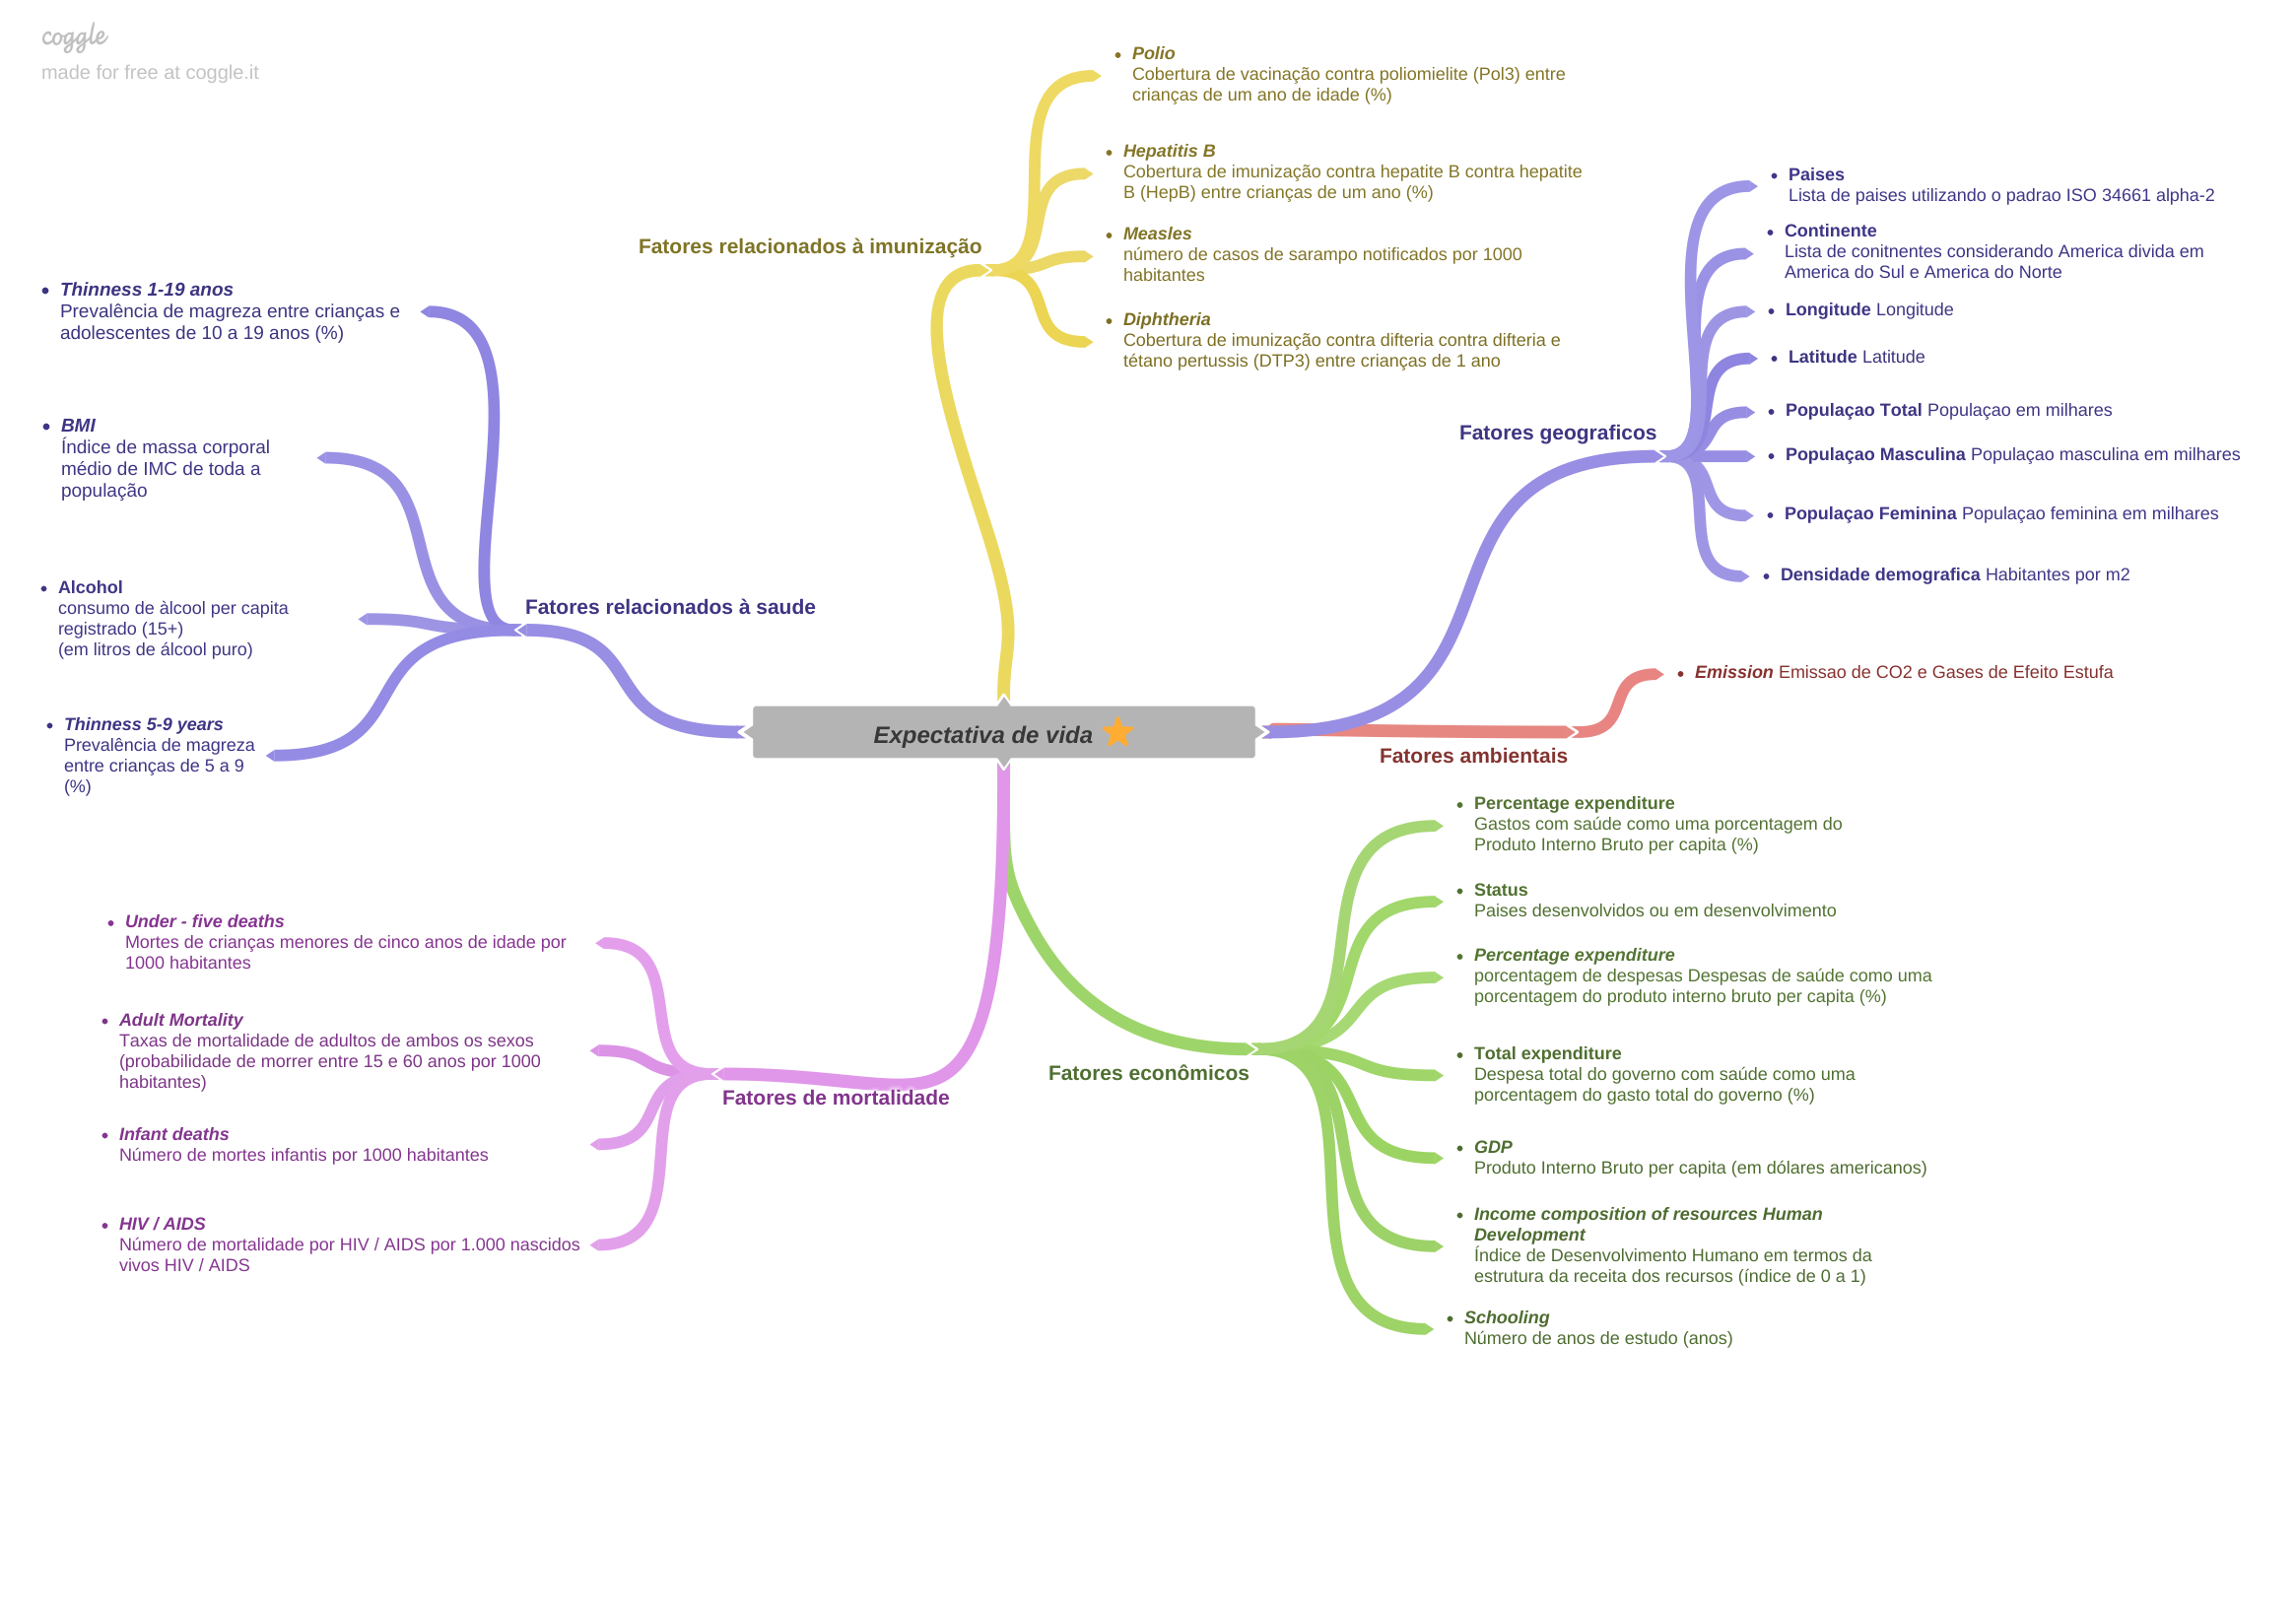

In [34]:
Image('../img/Expectativa_de_vida_star.png')

### Descriptive Statistics

In [35]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

#### Numerical Atributes

In [36]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,year,2000.00,2015.00,15.00,2007.52,2008.00,4.61,-0.01,-1.21
1,life_expectancy,36.30,89.00,52.70,69.22,NaN,9.52,-0.64,-0.23
2,adult_mortality,1.00,723.00,722.00,164.80,NaN,124.27,1.17,1.75
3,infant_deaths,0.00,1800.00,1800.00,30.30,3.00,117.91,9.79,116.04
4,alcohol,0.01,17.87,17.86,4.60,NaN,4.05,0.59,-0.80
5,percentage_expenditure,0.00,19479.91,19479.91,738.25,64.91,1987.58,4.65,26.57
6,hepatitis_b,1.00,99.00,98.00,80.94,NaN,25.06,-1.93,2.77
7,measles,0.00,212183.00,212183.00,2419.59,17.00,11465.32,9.44,114.86
8,bmi,1.00,87.30,86.30,38.32,NaN,20.04,-0.22,-1.29
9,under_five_deaths,0.00,2500.00,2500.00,42.04,4.00,160.42,9.50,109.75


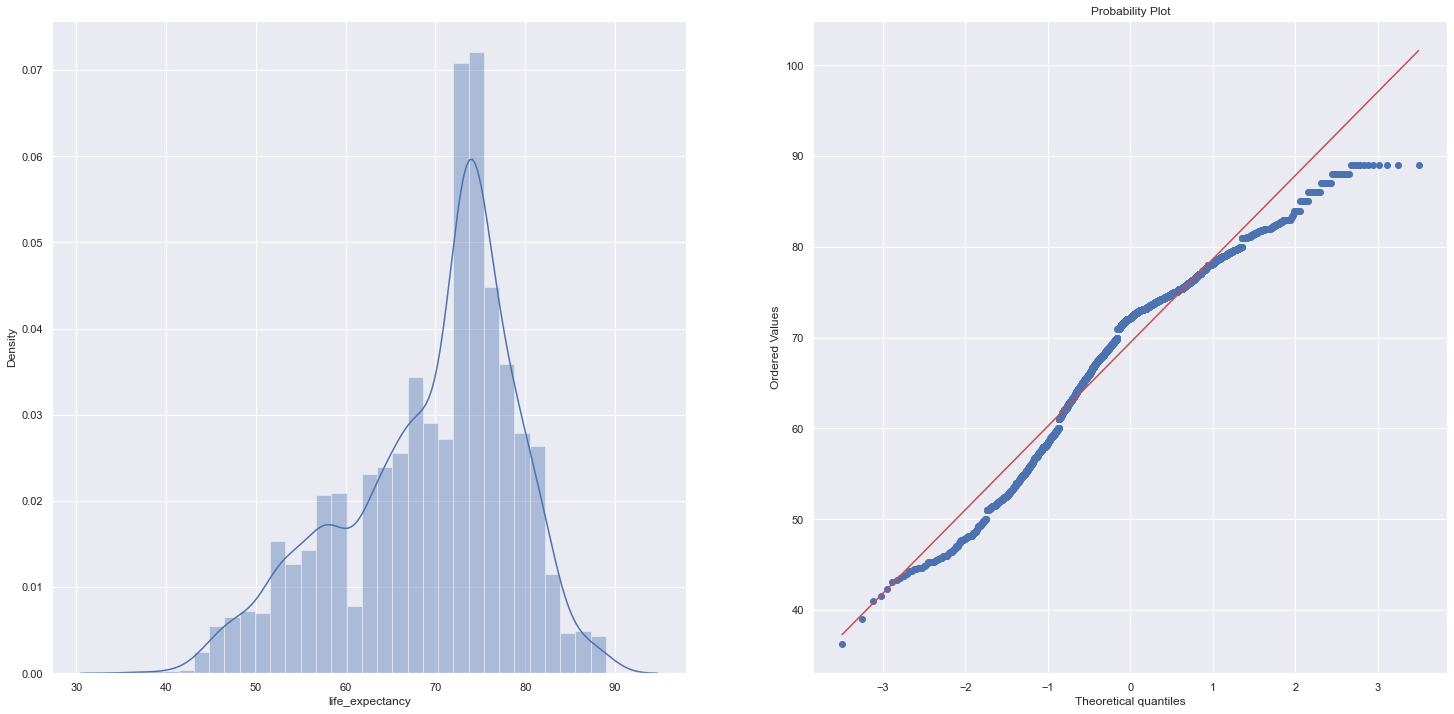

In [210]:
# Response variable
plt.subplot( 1, 2, 1)
sns.distplot(df1['life_expectancy']);

plt.subplot( 1, 2, 2 )
stats.probplot(df1['life_expectancy'],dist='norm',plot=pylab)
pylab.show()

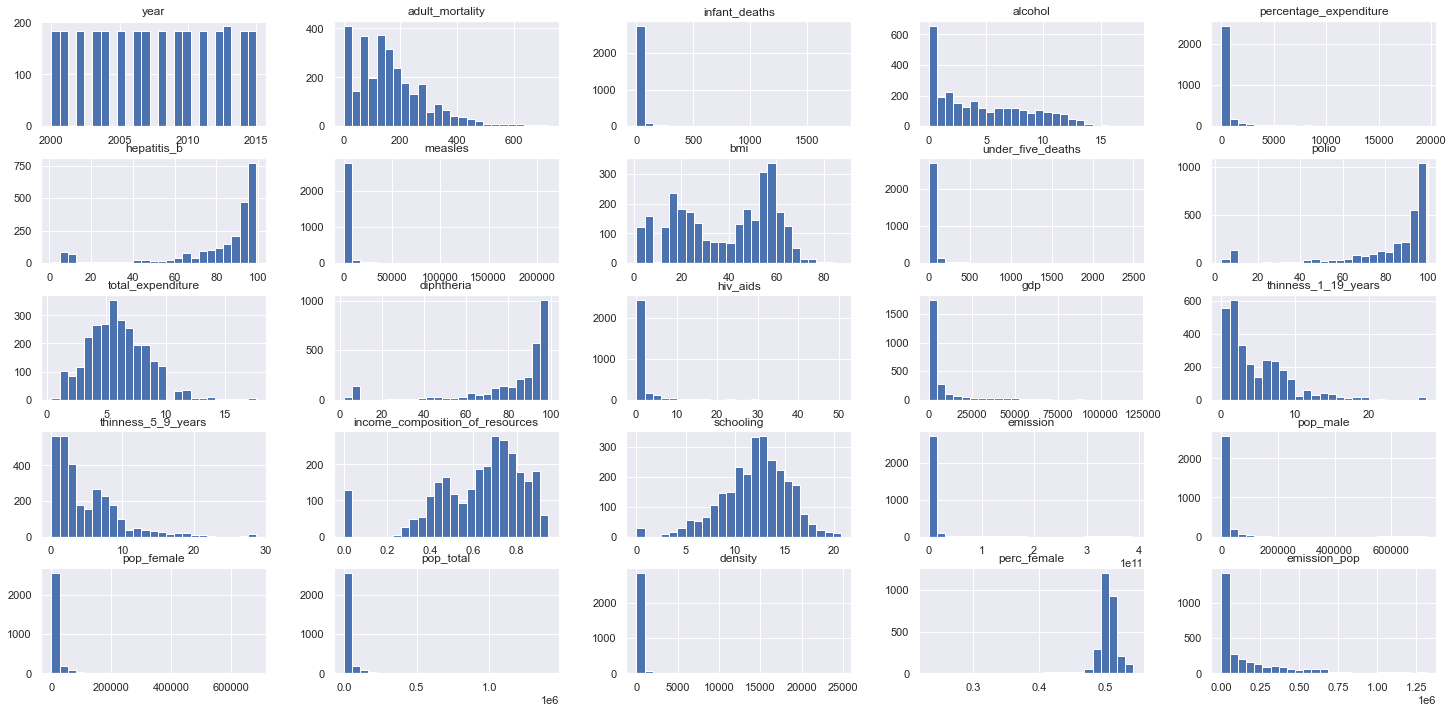

In [38]:
cols_drop = ['lat', 'long','life_expectancy']
num_attributes1=num_attributes.drop(cols_drop, axis=1 )
num_attributes1.hist( bins=25 );

#### Categorical Atributes

In [39]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

country      193
status         2
continent      6
code         188
dtype: int64

### Missing values


In [40]:
# duplicate
df1.drop_duplicates()

print('not exist data duplicated' )

print('numero de linhas:{}'.format(df1.shape[0]))
print('numero de colunas:{}'.format(df1.shape[1]))


not exist data duplicated
numero de linhas:2938
numero de colunas:32


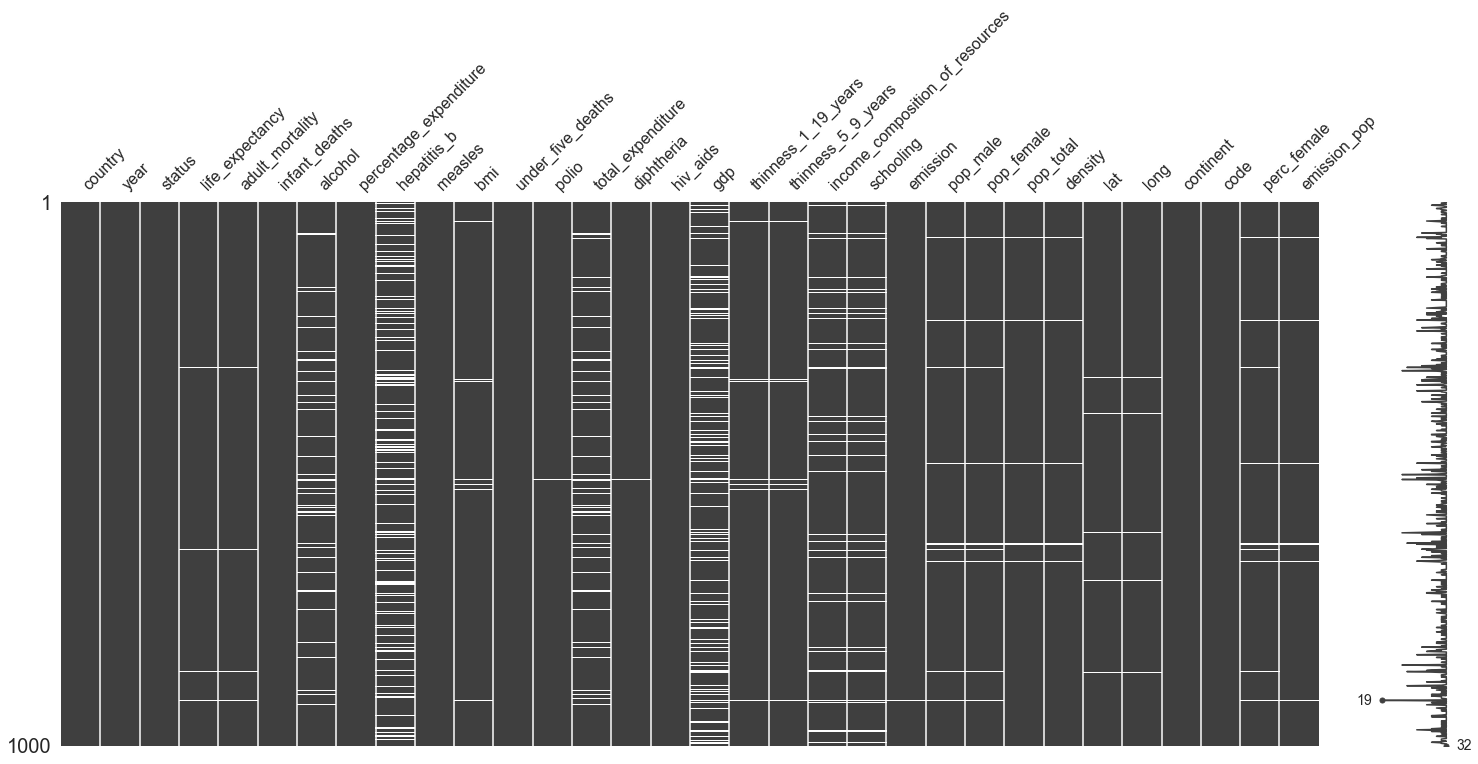

In [41]:
%matplotlib inline
msno.matrix(df1.sample(1000));

In [42]:
aux=df1.isna().sum().sort_values(ascending=False)
aux1=df1.isna().sum().sort_values(ascending=False)/df1.shape[0]*100

na=pd.concat([aux,aux1],axis=1)
na.columns=['NaN', 'NaN %']
na

,NaN,NaN %
hepatitis_b,553,18.82
gdp,448,15.25
total_expenditure,226,7.69
alcohol,194,6.60
income_composition_of_resources,167,5.68
schooling,163,5.55
thinness_1_19_years,34,1.16
bmi,34,1.16
thinness_5_9_years,34,1.16
perc_female,26,0.88


#### Bias  gdp

In [43]:
df1=df1.drop(['gdp'], axis=1) # drop original collumn 

df_gdp=pd.read_excel('../Datasets/GDPPC-USD-countries.xls',header=2)# New set Dataframe with standard country names 
df_gdp=df_gdp[['Country',2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010, 2011, 2012, 2013, 2014, 2015]]
df_gdp=df_gdp.melt(id_vars=['Country'])  # stacks the data with granularity in the country
df_gdp.columns=['country','year','gdp']
    

In [44]:
# Checking the country names

countryISO=df['country'].unique()

gdpcountry=df_gdp['country'].unique()

(set(countryISO) ^ set(gdpcountry))-set(countryISO)

(set(countryISO) ^ set(gdpcountry))-set(gdpcountry)

{"Democratic People's Republic of Korea",
 'Democratic Republic of the Congo',
 "Lao People's Democratic Republic",
 'Micronesia (Federated States of)',
 'Niue',
 'Saint Vincent and the Grenadines',
 'Swaziland',
 'The former Yugoslav republic of Macedonia',
 'United Kingdom of Great Britain and Northern Ireland',
 'United Republic of Tanzania',
 'United States of America'}

In [45]:
countryISO_unmatch=["Democratic People's Republic of Korea",
 'Democratic Republic of the Congo',
 "Lao People's Democratic Republic",
 'Micronesia (Federated States of)',
 'Saint Vincent and the Grenadines',
 'The former Yugoslav republic of Macedonia',
 'United Kingdom of Great Britain and Northern Ireland',
 'United Republic of Tanzania',
 'United States of America']

countrygdp_unmatch=[ 
 'D.P.R. of Korea',
 'D.R. of the Congo',
 "Lao People's DR",
 'Micronesia (FS of)',
 'St. Vincent and the Grenadines',
 'North Macedonia',
 'United Kingdom',
 'U.R. of Tanzania: Mainland',
 'United States',
]


dicgdp = dict(zip(countrygdp_unmatch,countryISO_unmatch))
df_gdp['country']=df_gdp['country'].replace(dicgdp)


df_gdp['year']=df_gdp['year'].astype(str)
df_gdp['year'] = pd.to_datetime( df_gdp['year'] ).dt.strftime('%Y')
df1['year']=df1['year'].astype(str)
df1['year'] = pd.to_datetime( df1['year'] ).dt.strftime('%Y')


df1=pd.merge(df1,df_gdp,how='left',on=['country','year'])

df1.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,total_expenditure,diphtheria,hiv_aids,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling,emission,pop_male,pop_female,pop_total,density,lat,long,continent,code,perc_female,emission_pop,gdp
0,Afghanistan,2015,Developing,65.00,263.00,62,0.01,71.28,65.00,1154,19.10,83,6.00,8.16,65.00,0.10,17.20,17.30,0.48,10.10,153230277.00,17686.17,16727.44,34413.60,52.71,33.77,66.24,AS,AF,0.49,4452.61,543.77
1,Afghanistan,2014,Developing,59.90,271.00,64,0.01,73.52,62.00,492,18.60,86,58.00,8.18,62.00,0.10,17.50,17.50,0.48,10.00,143122849.00,17138.80,16232.00,33370.80,51.12,33.77,66.24,AS,AF,0.49,4288.86,585.86
2,Afghanistan,2013,Developing,59.90,268.00,66,0.01,73.22,64.00,430,18.10,89,62.00,8.13,64.00,0.10,17.70,17.70,0.47,9.90,133333663.00,16554.28,15715.31,32269.59,49.43,33.77,66.24,AS,AF,0.49,4131.87,608.06
3,Afghanistan,2012,Developing,59.50,272.00,69,0.01,78.18,67.00,2787,17.60,93,67.00,8.52,67.00,0.10,17.90,18.00,0.46,9.80,123333249.00,15964.87,15196.50,31161.38,47.73,33.77,66.24,AS,AF,0.49,3957.89,614.11
4,Afghanistan,2011,Developing,59.20,275.00,71,0.01,7.10,68.00,3013,17.20,97,68.00,7.87,68.00,0.10,18.20,18.20,0.45,9.50,112591192.00,15415.36,14702.05,30117.41,46.13,33.77,66.24,AS,AF,0.49,3738.41,576.10


#### NaN com algoritmo KNN

In [46]:
knn_imputer = KNNImputer(n_neighbors=5, weights="uniform",metric='nan_euclidean')
df1['hepatitis_b'] = knn_imputer.fit_transform(df1[['hepatitis_b']])
df1['alcohol'] = knn_imputer.fit_transform(df1[['alcohol']])
df1['total_expenditure'] = knn_imputer.fit_transform(df1[['total_expenditure']])
df1['income_composition_of_resources'] = knn_imputer.fit_transform(df1[['income_composition_of_resources']])
df1['schooling'] = knn_imputer.fit_transform(df1[['schooling']])

#### NaN lat long

In [47]:
null_cols_code=df1.loc[df1['long'].isnull(),'country'].unique()
null_cols_code

array(['Brunei Darussalam', 'Sierra Leone',
       'The former Yugoslav republic of Macedonia'], dtype=object)

In [48]:
lat=[-16.2837065,32.4207423,41.6137143]
lon=[-63.5493965,53.6830157,21.743258]

for i in range(len(null_cols_code)):
    for j in range(len(df1)):
        if null_cols_code[i] == df1.loc[j,'country'] :
            df1.loc[j,'lat']=lat[i]
            df1.loc[j,'long']=lon[i]

#### Eliminar NaN

In [49]:
df1.isna().sum().sort_values(ascending=False)

thinness_1_19_years                34
bmi                                34
thinness_5_9_years                 34
gdp                                33
perc_female                        26
pop_female                         26
pop_male                           26
polio                              19
diphtheria                         19
emission_pop                       18
density                            16
pop_total                          16
adult_mortality                    10
life_expectancy                    10
emission                            2
code                                0
continent                           0
long                                0
lat                                 0
income_composition_of_resources     0
schooling                           0
infant_deaths                       0
status                              0
year                                0
hiv_aids                            0
total_expenditure                   0
under_five_d

In [50]:
# drop NaN's 
df1= df1.dropna(subset=['gdp','polio','bmi','life_expectancy'])

In [51]:
df1.isna().sum().sort_values(ascending=False)

country                            0
year                               0
emission_pop                       0
perc_female                        0
code                               0
continent                          0
long                               0
lat                                0
density                            0
pop_total                          0
pop_female                         0
pop_male                           0
emission                           0
schooling                          0
income_composition_of_resources    0
thinness_5_9_years                 0
thinness_1_19_years                0
hiv_aids                           0
diphtheria                         0
total_expenditure                  0
polio                              0
under_five_deaths                  0
bmi                                0
measles                            0
hepatitis_b                        0
percentage_expenditure             0
alcohol                            0
i

In [52]:
print('novo numero de linhas:{}'.format(df1.shape[0]))
print('novo numero de colunas:{}'.format(df1.shape[1]))

novo numero de linhas:2872
novo numero de colunas:32


## Exploratory Data Analysis


In [60]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [61]:
df2=df1.copy()

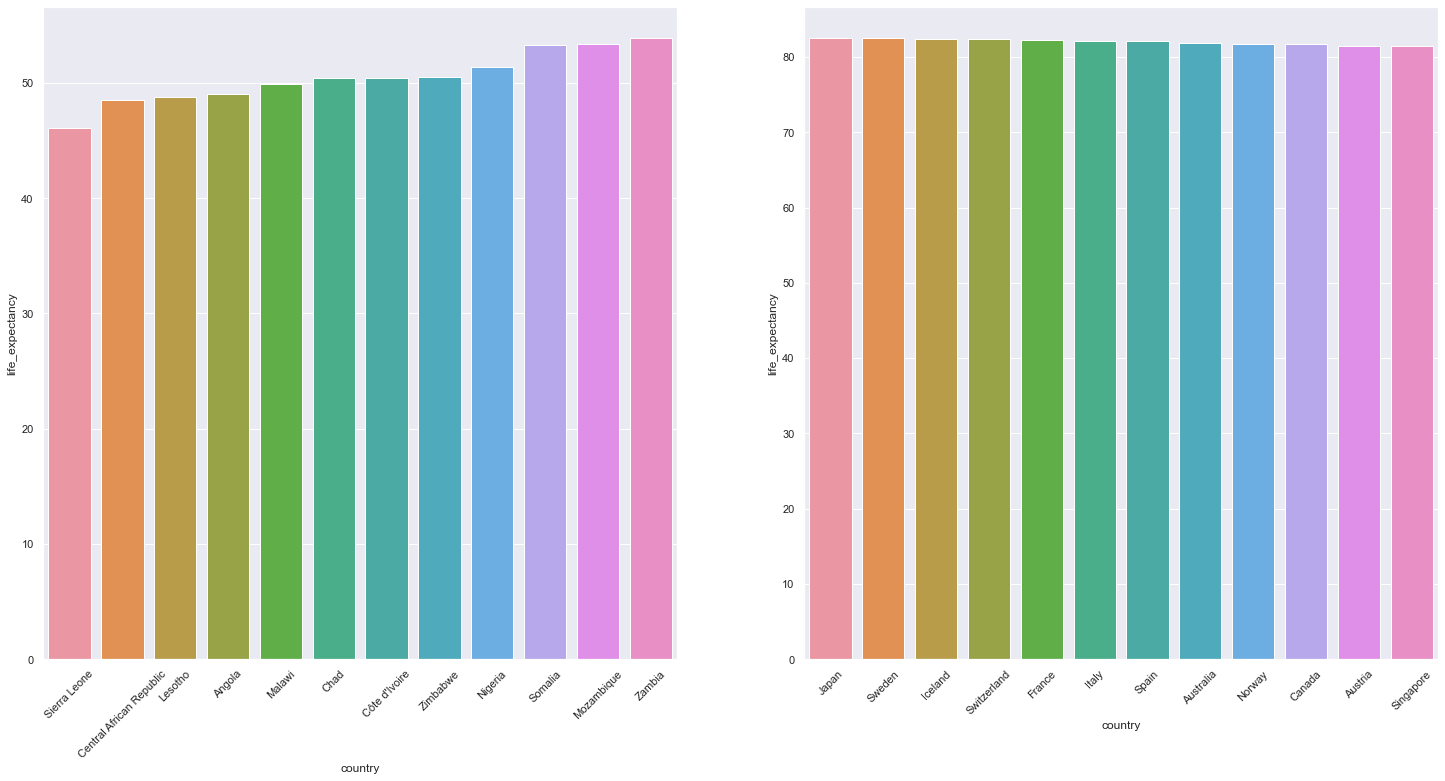

In [114]:
## continent
plt.subplot( 1, 2, 2)
a=df2[['country','life_expectancy']].groupby('country').mean().sort_values(ascending=False,by='life_expectancy').reset_index()
a=a.head(12)
sns.barplot(x='country',y='life_expectancy',data=a);
plt.xticks(rotation=45);

plt.subplot( 1, 2, 1 )
b=df2[['country','life_expectancy']].groupby('country').mean().sort_values(ascending=True,by='life_expectancy').reset_index()
b=b.head(12)
sns.barplot(x='country',y='life_expectancy',data=b);
plt.xticks(rotation=45);


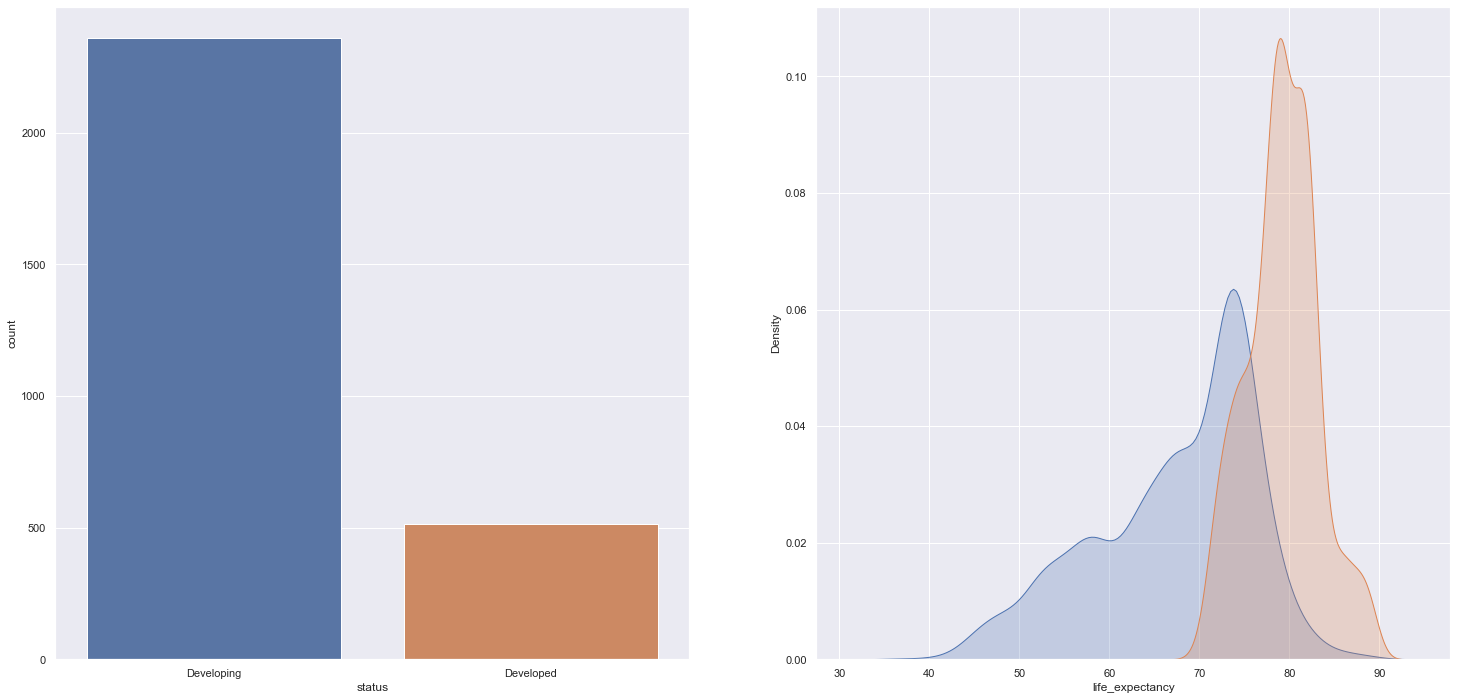

In [116]:
## Status

plt.subplot( 1, 2, 1 )
sns.countplot( df1['status'] )

plt.subplot( 1, 2, 2 )
sns.kdeplot( df1[df1['status'] =='Developing']['life_expectancy'], label='status', shade=True )
sns.kdeplot( df1[df1['status'] =='Developed']['life_expectancy'], label='status', shade=True );

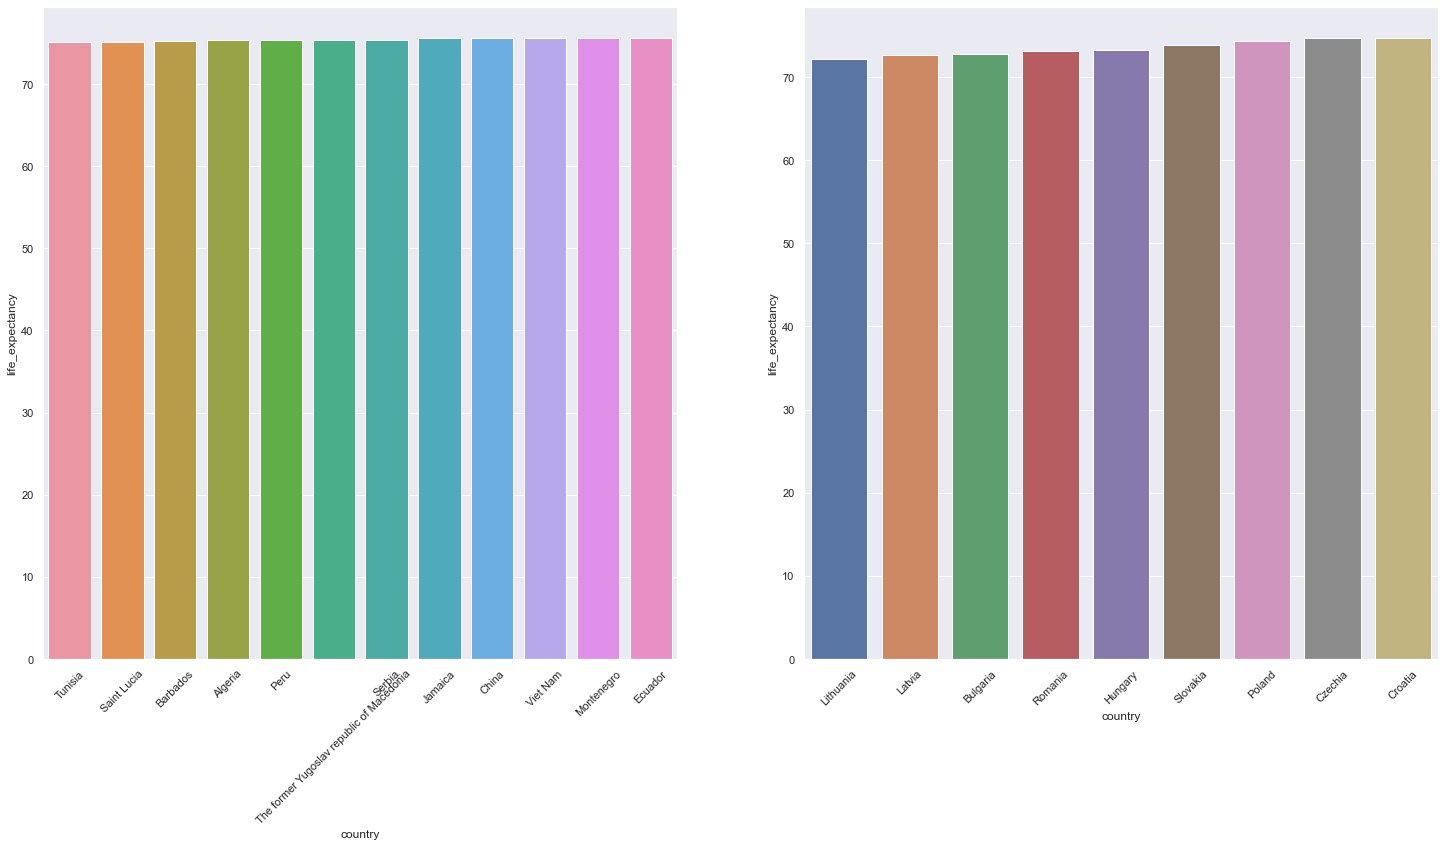

In [123]:

df_statusb=df2[df2['status']=='Developing']
df_statusb=df_statusb[df_statusb['life_expectancy']>75]

plt.subplot( 1, 2, 1 )
b=df_statusb[['country','life_expectancy']].groupby('country').mean().sort_values(ascending=True,by='life_expectancy').reset_index()
b=b.head(12)
sns.barplot(x='country',y='life_expectancy',data=b);
plt.xticks(rotation=45);

plt.subplot( 1, 2, 2)
a=df_statusa[['country','life_expectancy']].groupby('country').mean().sort_values(ascending=True,by='life_expectancy').reset_index()
a=a.head(12)
sns.barplot(x='country',y='life_expectancy',data=a);
plt.xticks(rotation=45);

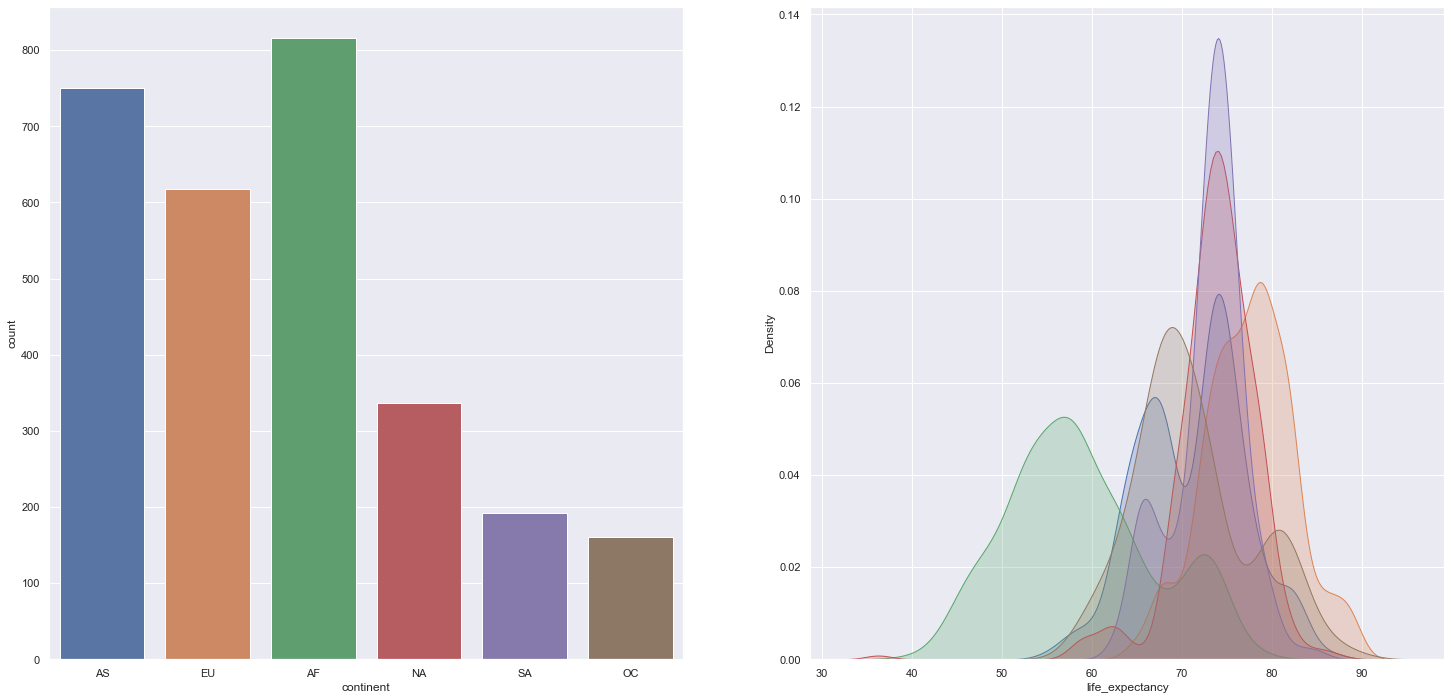

In [124]:
## continent
plt.subplot( 1, 2, 1 )
sns.countplot( df1['continent'] )

plt.subplot( 1, 2, 2 )
sns.kdeplot( df1[df1['continent'] =='AS']['life_expectancy'], label='continent', shade=True )
sns.kdeplot( df1[df1['continent'] =='EU']['life_expectancy'], label='continent', shade=True )
sns.kdeplot( df1[df1['continent'] =='AF']['life_expectancy'], label='continent', shade=True )
sns.kdeplot( df1[df1['continent'] =='NA']['life_expectancy'], label='continent', shade=True )
sns.kdeplot( df1[df1['continent'] =='SA']['life_expectancy'], label='continent', shade=True )
sns.kdeplot( df1[df1['continent'] =='OC']['life_expectancy'], label='continent', shade=True );

### **H1** - Países densamente povoados ou altamaente populosos tendem a ter menor expectativa de vida?

In [125]:
map=df2[['continent','status','country','lat','long','pop_total','density','life_expectancy']].groupby(['continent','country','status']).mean().reset_index()
map.head()

,continent,country,status,lat,long,pop_total,density,life_expectancy
0,AF,Algeria,Developing,28.00,3.00,34821.37,14.62,73.62
1,AF,Angola,Developing,-11.88,17.57,21622.86,17.34,49.02
2,AF,Benin,Developing,9.53,2.26,8628.81,76.52,57.57
3,AF,Botswana,Developing,-23.17,24.59,1888.51,3.33,56.05
4,AF,Burkina Faso,Developing,12.08,-1.69,14618.29,53.43,55.64


In [126]:
    fig=px.scatter_mapbox(map,
                          hover_name='country',
                          hover_data=["life_expectancy", "density",'status'],
                          lat='lat',
                          lon='long',
                          size='density',
                          color='life_expectancy',
                          color_continuous_scale=px.colors.cyclical.IceFire_r,
                          size_max=60,
                          zoom=1)

    fig.update_layout(mapbox_style='open-street-map')
    fig.update_layout(height=400, margin={'r':0,'l':0,'t':0,'b':0})
    fig.show()

In [127]:
fig=px.scatter_mapbox(map,
                          hover_name='country',
                          hover_data=["life_expectancy", "density",'status'],
                          lat='lat',
                          lon='long',
                          size='pop_total',
                          color='life_expectancy',
                          color_continuous_scale=px.colors.cyclical.IceFire_r,
                          size_max=60,
                          zoom=1)

fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(height=400, margin={'r':0,'l':0,'t':0,'b':0})
fig.show()

###  **H2**- Como è a variaçao da expectativa de vida dentro dos continentes


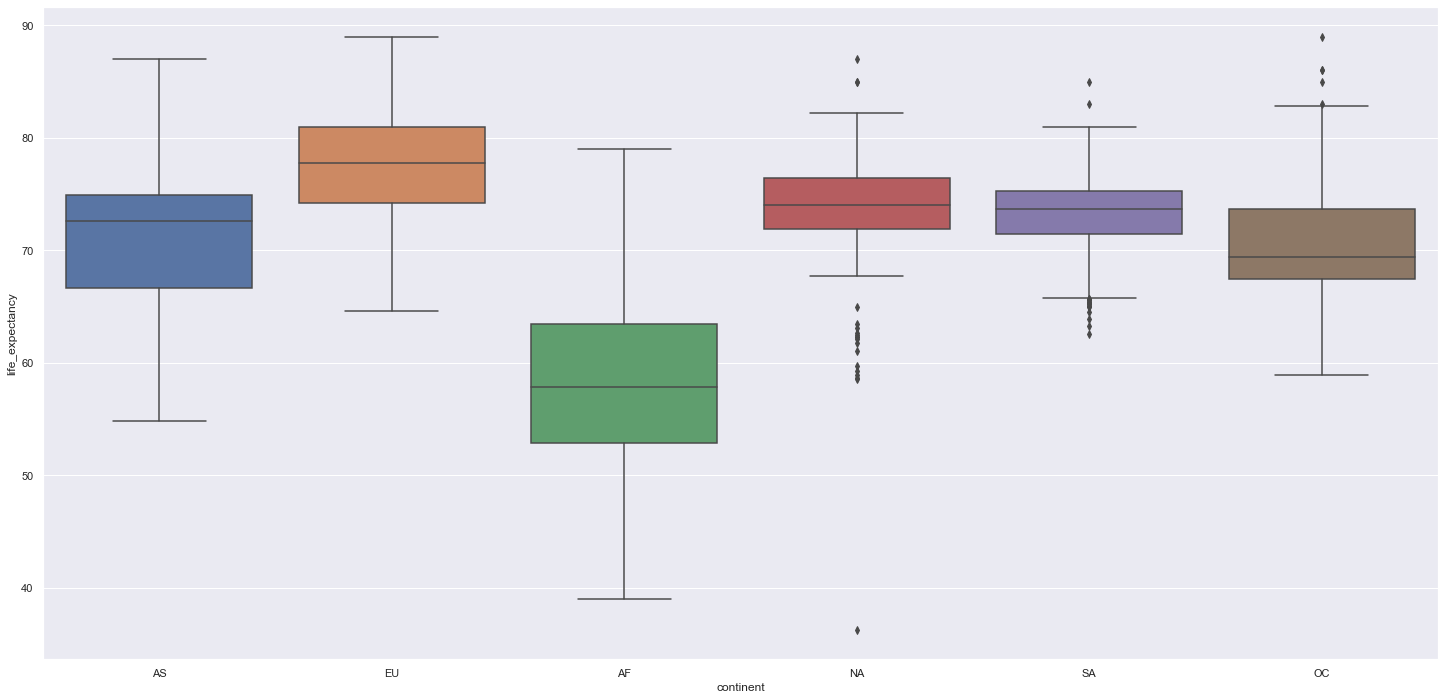

In [71]:
aux = df2[['continent','country','life_expectancy','year']]

#life_expectancy per continent
sns.boxplot( x='continent', y='life_expectancy',data=df2);


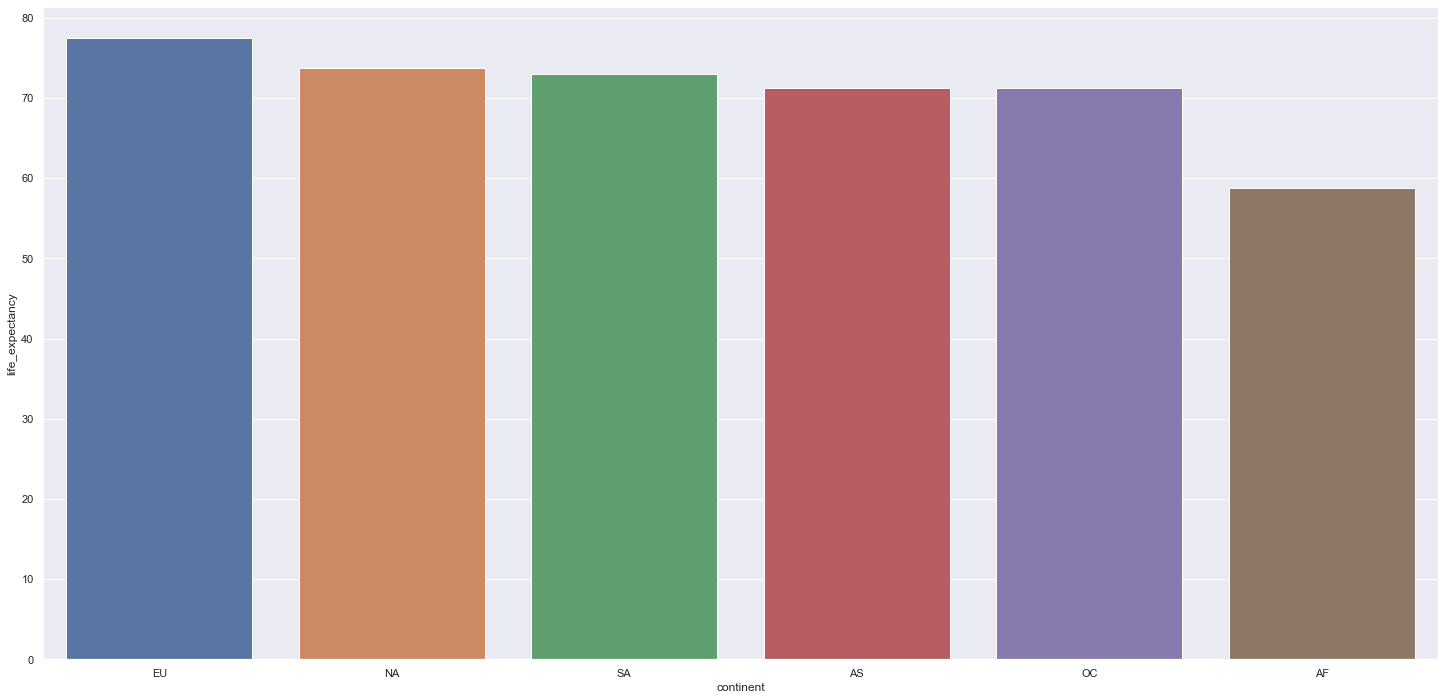

In [72]:
## continent

a=df2[['continent','life_expectancy']].groupby('continent').mean().sort_values(ascending=False,by='life_expectancy').reset_index()
a=a.head(12)
sns.barplot(x='continent',y='life_expectancy',data=a);

### **H3** - Como foi a evolucaçao da expectativa de vida ao longo dos anos

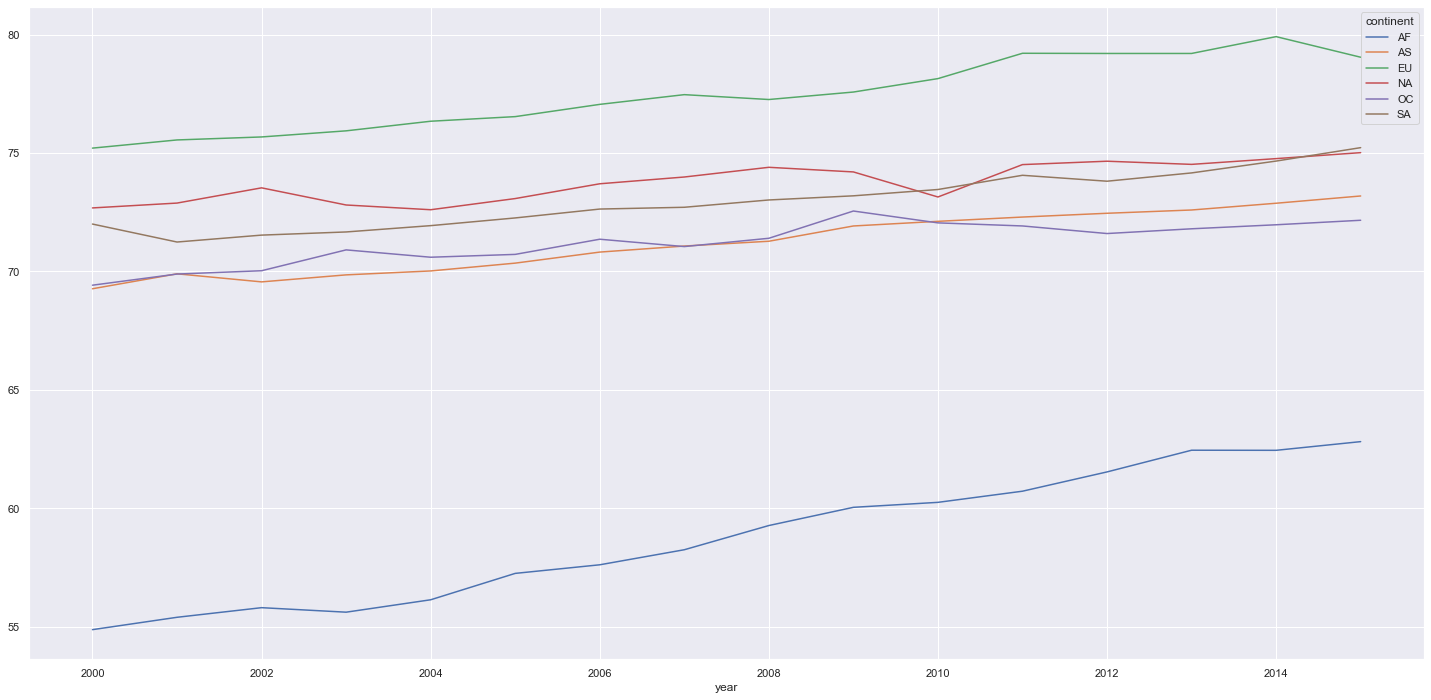

In [73]:
#life_expectancy mean per year
aux1 = df2[['year','continent','life_expectancy']].groupby(['continent','year']).mean().reset_index()
aux1.pivot(index='year',columns='continent',values='life_expectancy').plot();

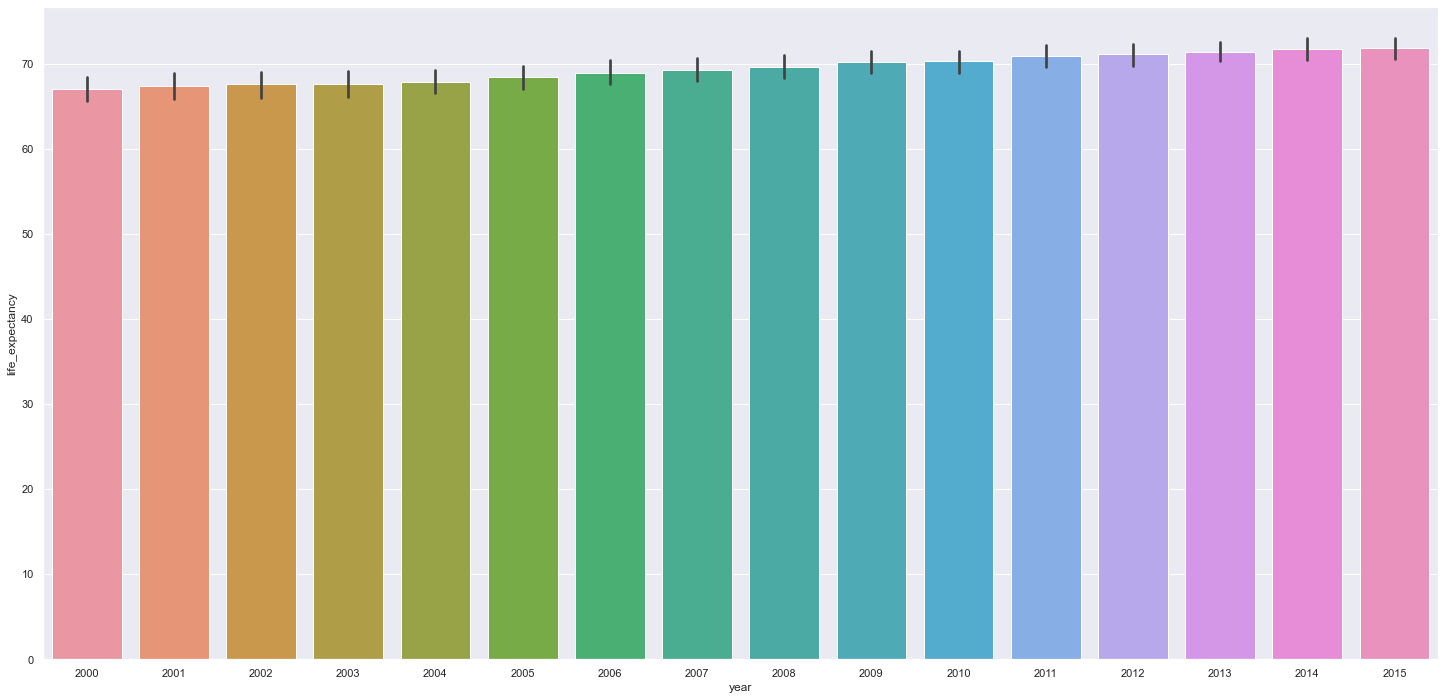

In [106]:
#life_expectancy mean per year
aux1 = df2[['year','country','life_expectancy']].groupby(['country','year']).mean().reset_index()
sns.barplot(x='year',y='life_expectancy',data=aux1);


###  **H4**  - Como as taxas de mortalidade de bebês e adultos afetam a expectativa de vida?


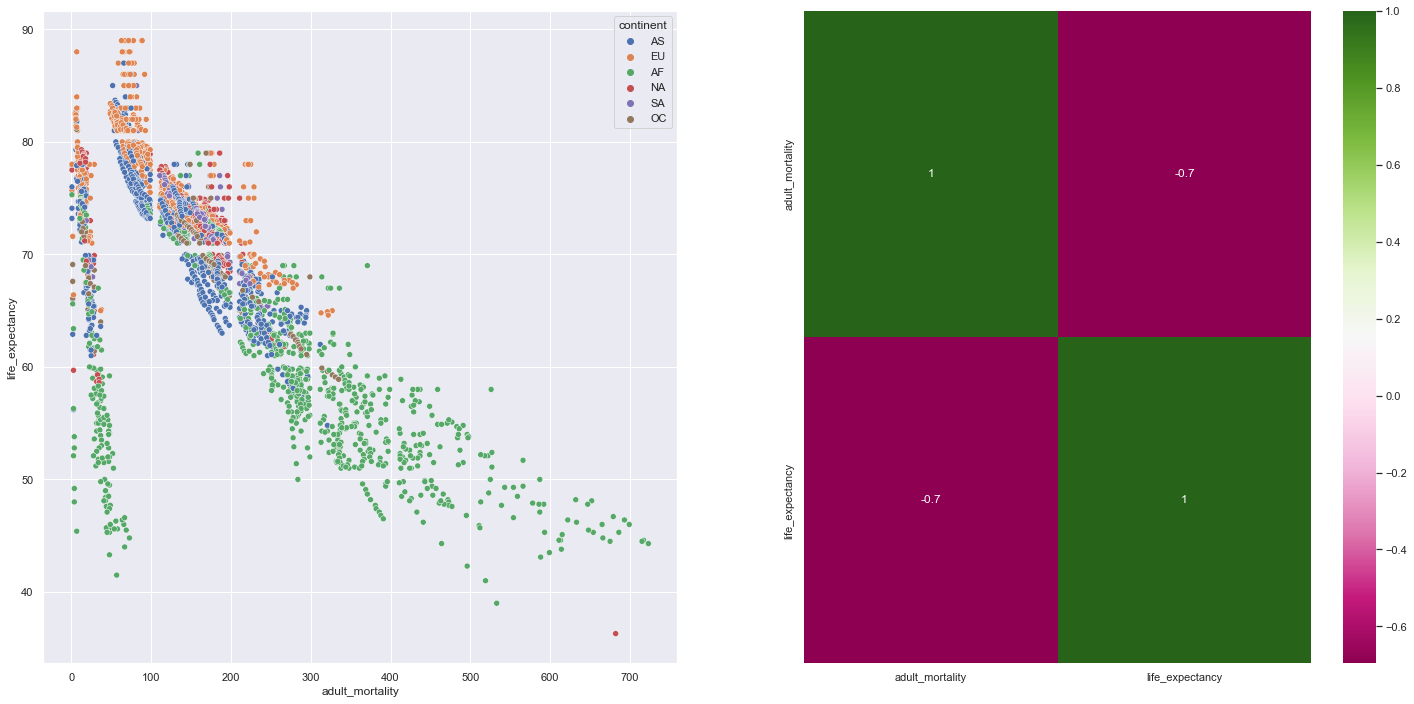

In [75]:
aux2 = df2[['adult_mortality','life_expectancy','continent']]

plt.subplot( 1, 2, 1 )
sns.scatterplot(x='adult_mortality',y='life_expectancy',hue='continent',data=df2)

plt.subplot( 1, 2, 2 )
sns.heatmap(aux2.corr(method='pearson'),annot=True,cmap="PiYG");

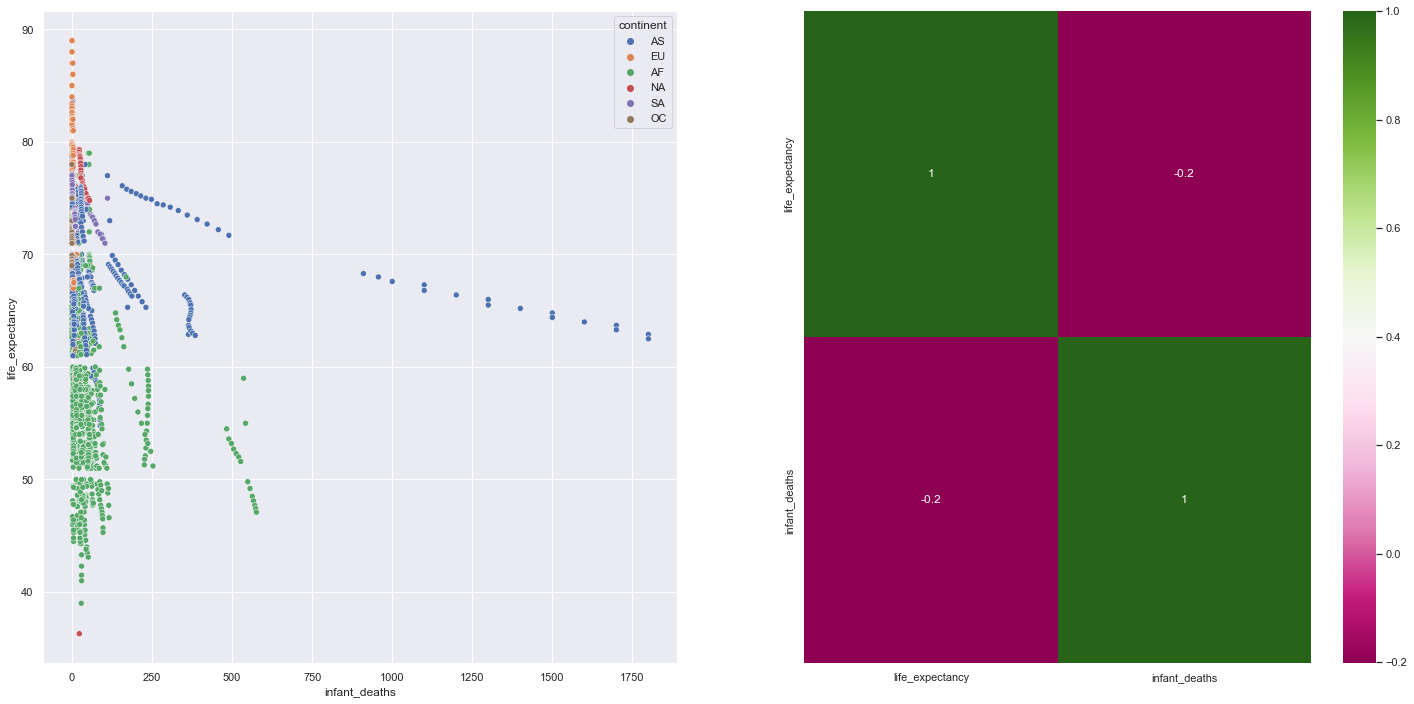

In [76]:
aux3 = df2[['life_expectancy','infant_deaths','continent']]

plt.subplot( 1, 2, 1 )
sns.scatterplot(x='infant_deaths',y='life_expectancy',hue='continent', data=df2);

plt.subplot( 1, 2, 2 )
sns.heatmap(aux3.corr(method='pearson'),annot=True,cmap="PiYG");


### **H5**  - Qual é o impacto da escolaridade na expectativa de vida?


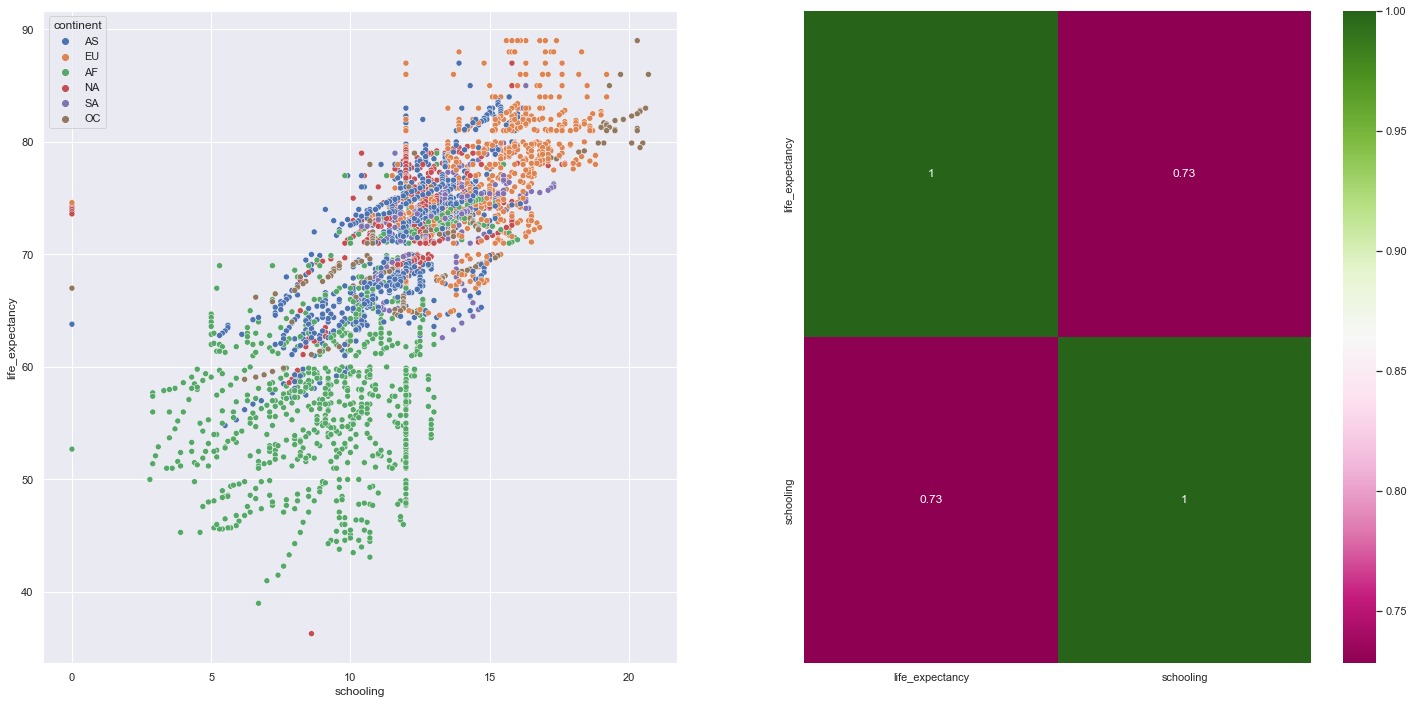

In [77]:
aux4 = df2[['life_expectancy','schooling','continent']]

plt.subplot( 1, 2, 1 )
sns.scatterplot(x='schooling',y='life_expectancy',hue='continent', data=df2);

plt.subplot( 1, 2, 2 )
sns.heatmap(aux4.corr(method='pearson'),annot=True,cmap="PiYG");


### **H6**  - A expectativa de vida tem uma relação positiva ou negativa com o consumo de álcool?


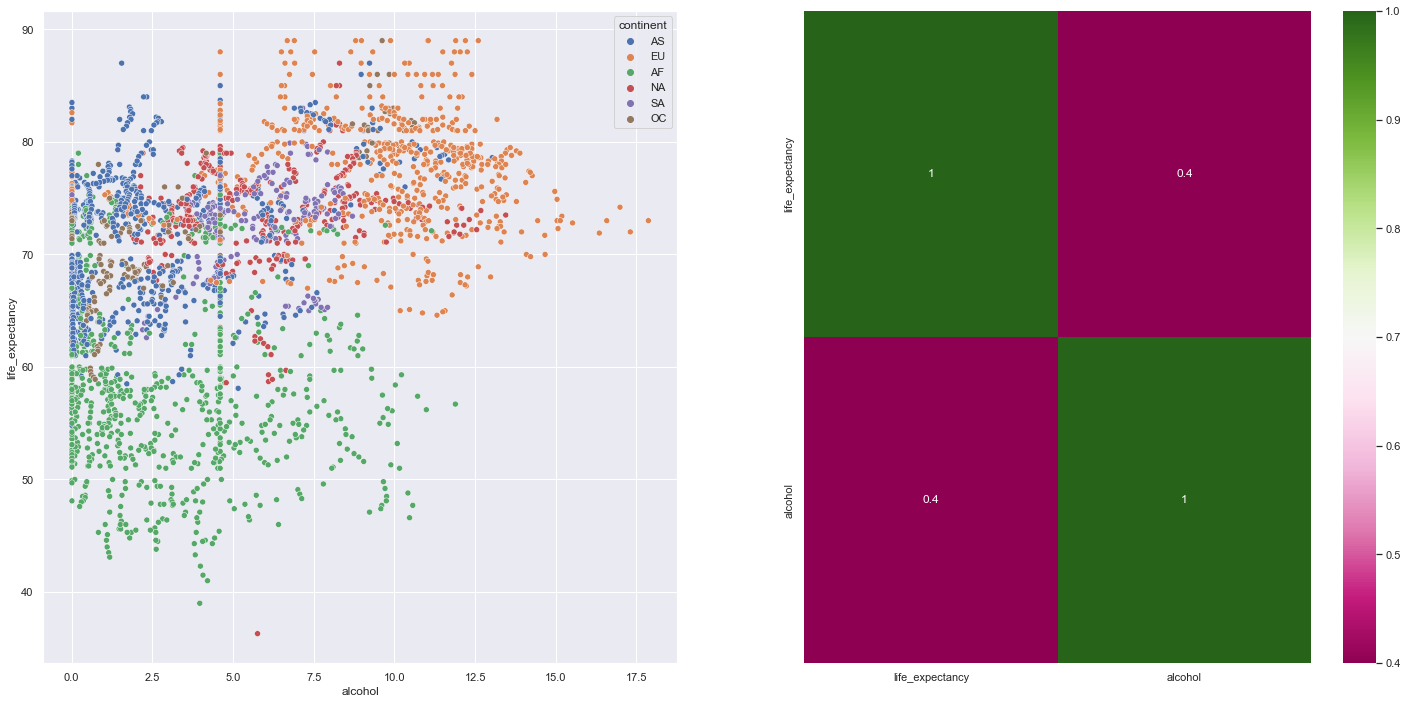

In [78]:
aux5 = df2[['life_expectancy','alcohol','continent']]

plt.subplot( 1, 2, 1 )
sns.scatterplot(x='alcohol',y='life_expectancy',hue='continent', data=df2);

plt.subplot( 1, 2, 2 )
sns.heatmap(aux5.corr(method='pearson'),annot=True,cmap="PiYG");


### **H7**  - Paises mais inquinados representam uma expectativa de vida menor?

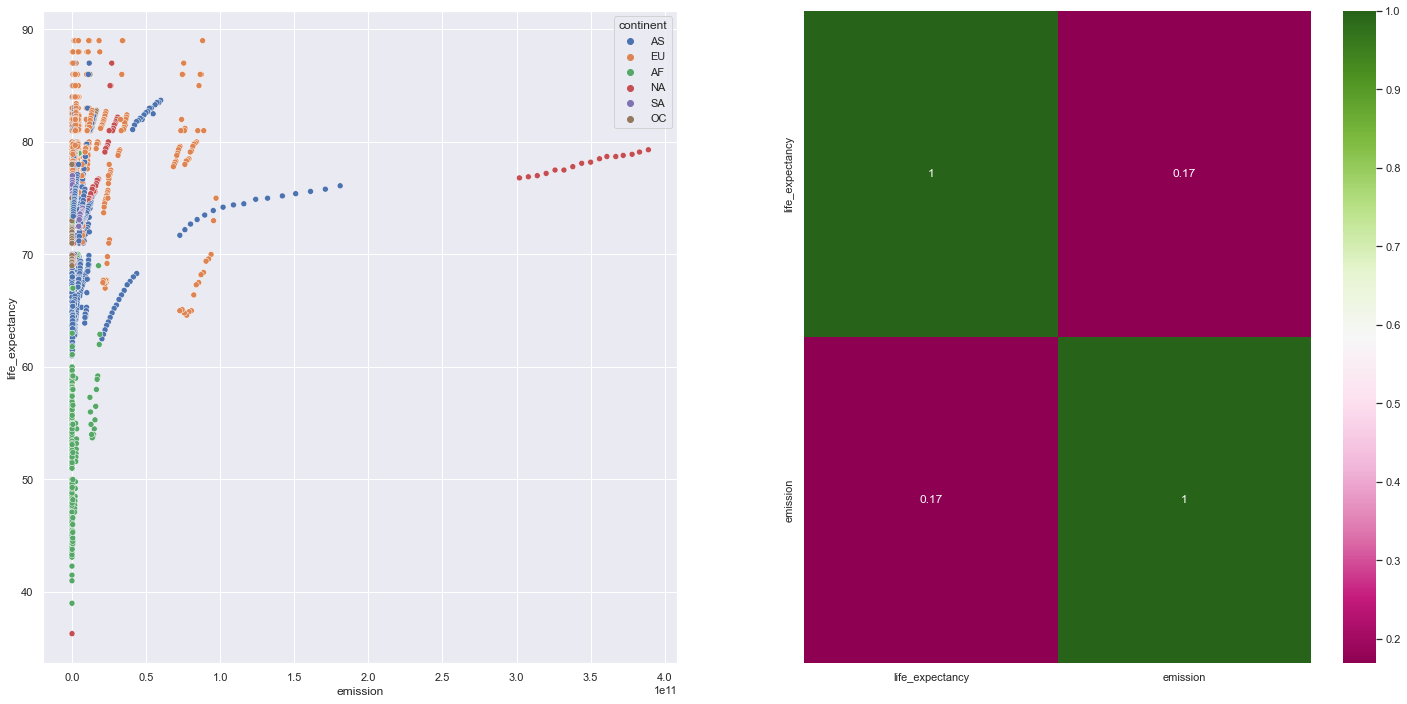

In [79]:
aux6 = df2[['life_expectancy','emission','continent']]

plt.subplot( 1, 2, 1 )
sns.scatterplot(x='emission',y='life_expectancy',hue='continent', data=df2);

plt.subplot( 1, 2, 2 )
sns.heatmap(aux6.corr(method='pearson'),annot=True,cmap="PiYG");


### **H8**  - Qual é o impacto da cobertura de imunização na expectativa de vida?

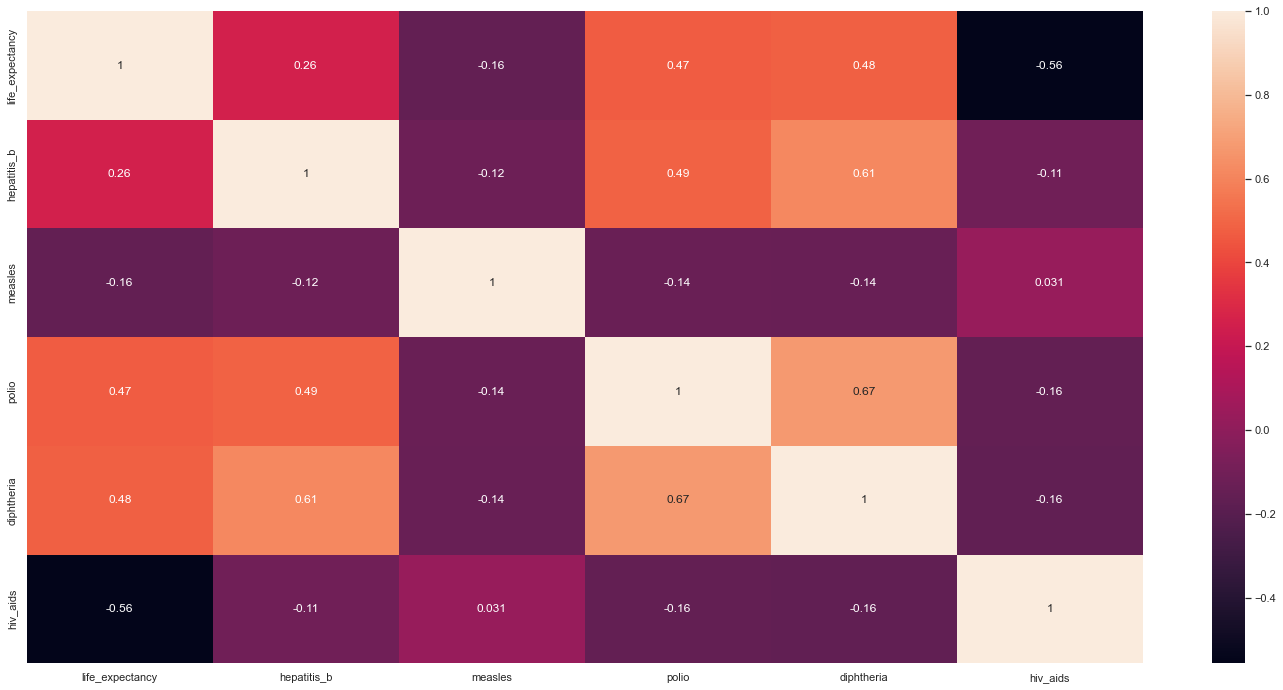

In [80]:
cols_drop = ['adult_mortality', 'infant_deaths',
       'alcohol', 'percentage_expenditure', 'bmi',
       'under_five_deaths', 'total_expenditure', 'gdp', 'pop_total', 'thinness_1_19_years',
       'thinness_5_9_years', 'income_composition_of_resources', 'schooling',
       'emission', 'lat', 'long','year','emission_pop','perc_female','density','pop_male','pop_female']

num_attributes2=num_attributes.drop(cols_drop, axis=1 )
correlation = num_attributes2.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

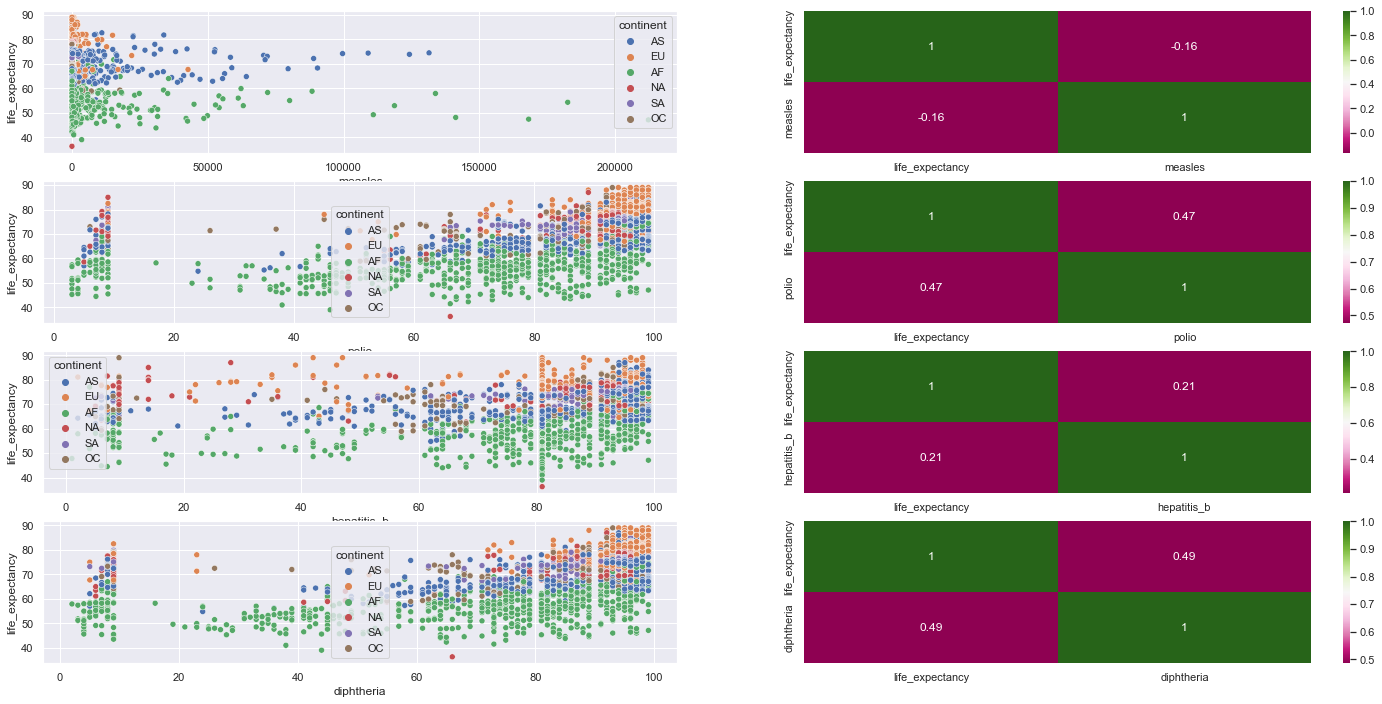

In [81]:
aux7 = df2[['life_expectancy','measles','continent']]
aux8 = df2[['life_expectancy','polio','continent']]
aux9 = df2[['life_expectancy','hepatitis_b','continent']]
aux0 = df2[['life_expectancy','diphtheria','continent']]

plt.subplot( 4, 2, 1 )
sns.scatterplot(x='measles',y='life_expectancy',hue='continent', data=df2);

plt.subplot( 4, 2, 2 )
sns.heatmap(aux7.corr(method='pearson'),annot=True,cmap="PiYG");

plt.subplot( 4, 2, 3 )
sns.scatterplot(x='polio',y='life_expectancy',hue='continent', data=df2);

plt.subplot( 4, 2, 4 )
sns.heatmap(aux8.corr(method='pearson'),annot=True,cmap="PiYG");

plt.subplot( 4, 2, 5 )
sns.scatterplot(x='hepatitis_b',y='life_expectancy',hue='continent', data=df2);

plt.subplot( 4, 2, 6)
sns.heatmap(aux9.corr(method='pearson'),annot=True,cmap="PiYG");

plt.subplot( 4, 2, 7 )
sns.scatterplot(x='diphtheria',y='life_expectancy',hue='continent', data=df2);

plt.subplot( 4, 2, 8)
sns.heatmap(aux0.corr(method='pearson'),annot=True,cmap="PiYG");

### **H9**  - A expectativa de vida tem correlação positiva ou negativa com hábitos alimentares, estilo de vida, exercícios, fumo, bebida alcoólica etc.


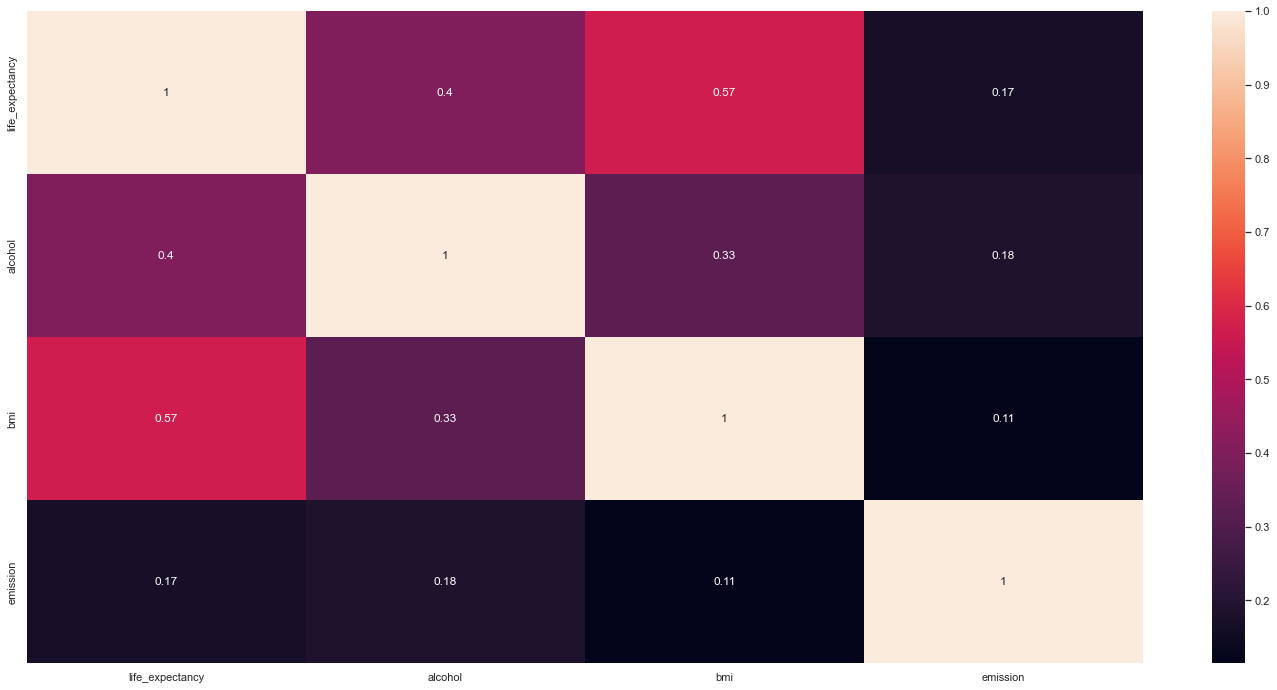

In [82]:
num_attributes1 =df2[['life_expectancy', 'alcohol', 'bmi', 'emission']]
correlation = num_attributes1.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### Numerical Heatmap 

In [83]:
df3=df2.copy()
num_attributes4 = df3.select_dtypes( include=['int64', 'float64'] )
cat_attributes4 = df3.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

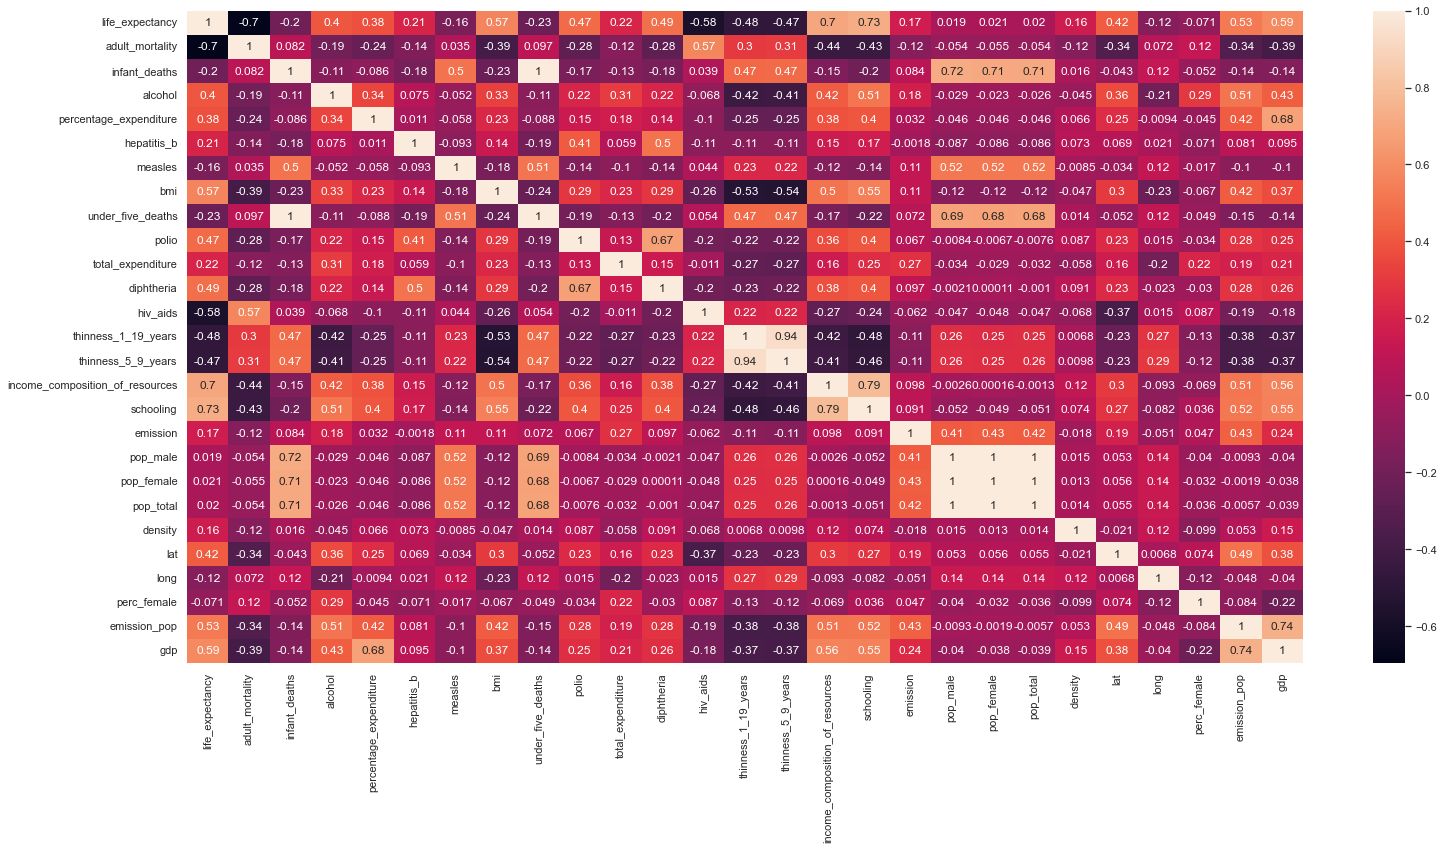

In [84]:
correlation = num_attributes4.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### Categorical Heatmap 

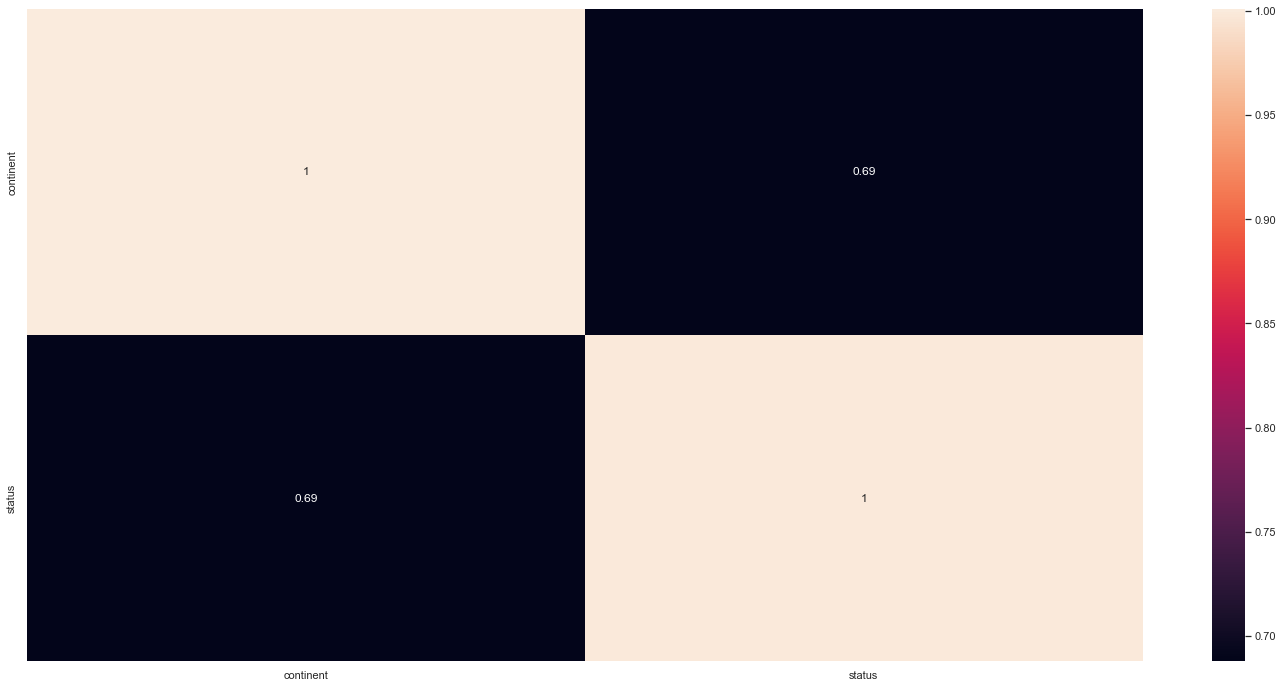

In [85]:
# # # Calculate cramer V
a = df2.select_dtypes( include='object' )

a1 = cramer_v( a['continent'], a['continent'] )
a2 = cramer_v( a['continent'], a['status'] )
a3 = cramer_v( a['status'], a['continent'] )
a4 = cramer_v( a['status'], a['status'] )



# # Final dataset
d = pd.DataFrame( {'continent': [a1, a2],'status': [a3, a4]})
d = d.set_index( d.columns )
sns.heatmap( d, annot=True );

## **Preprocessing Data**

In [424]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [425]:
df3=df2.copy()

In [426]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2872 entries, 0 to 2937
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   country                          2872 non-null   object 
 1   year                             2872 non-null   object 
 2   status                           2872 non-null   object 
 3   life_expectancy                  2872 non-null   float64
 4   adult_mortality                  2872 non-null   float64
 5   infant_deaths                    2872 non-null   int64  
 6   alcohol                          2872 non-null   float64
 7   percentage_expenditure           2872 non-null   float64
 8   hepatitis_b                      2872 non-null   float64
 9   measles                          2872 non-null   int64  
 10  bmi                              2872 non-null   float64
 11  under_five_deaths                2872 non-null   int64  
 12  polio               

In [427]:
rs = RobustScaler()
mms = MinMaxScaler()
le=LabelEncoder()

### Robust Scaler

**Variaveis a serem rescaladas:** (problema con range)
 - emission
 - gdp
 - infant_deaths
 - percentage_expenditure
 - measles
 - under_five_deaths
 - pop_male
 - pop_female
 - pop_total
 - density
 - perc_female
 - emission_pop


In [428]:
df3['emission'] = rs.fit_transform( df3[['emission']].values )
df3['gdp'] = rs.fit_transform( df3[['gdp']].values )
df3['infant_deaths'] = rs.fit_transform( df3[['infant_deaths']].values )
df3['percentage_expenditure'] = rs.fit_transform( df3[['percentage_expenditure']].values )
df3['measles'] = rs.fit_transform( df3[['measles']].values )
df3['under_five_deaths'] = rs.fit_transform( df3[['under_five_deaths']].values )
df3['pop_male'] = rs.fit_transform( df3[['pop_male']].values )
df3['pop_female'] = rs.fit_transform( df3[['pop_female']].values )
df3['pop_total'] = rs.fit_transform( df3[['pop_total']].values )
df3['density'] = rs.fit_transform( df3[['density']].values )
df3['perc_female'] = rs.fit_transform( df3[['perc_female']].values )
df3['emission_pop'] = rs.fit_transform( df3[['emission_pop']].values )

### Transformation

#### Order Encoder

 - year

In [429]:
a=['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015']
b=np.arange(1,17,1)
year_dict = dict(zip(a, b))
df3['year']=df3['year'].map(year_dict)
df3.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,total_expenditure,diphtheria,hiv_aids,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling,emission,pop_male,pop_female,pop_total,density,lat,long,continent,code,perc_female,emission_pop,gdp
0,Afghanistan,16,Developing,65.00,263.00,2.81,0.01,0.01,65.00,3.17,19.10,3.04,6.00,8.16,65.00,0.10,17.20,17.30,0.48,10.10,-0.08,1.22,1.12,1.16,-0.17,33.77,66.24,AS,AF,-1.31,-0.21,-0.28
1,Afghanistan,15,Developing,59.90,271.00,2.90,0.01,0.01,62.00,1.32,18.60,3.15,58.00,8.18,62.00,0.10,17.50,17.50,0.48,10.00,-0.09,1.17,1.08,1.12,-0.18,33.77,66.24,AS,AF,-1.28,-0.21,-0.27
2,Afghanistan,14,Developing,59.90,268.00,3.00,0.01,0.01,64.00,1.15,18.10,3.27,62.00,8.13,64.00,0.10,17.70,17.70,0.47,9.90,-0.09,1.12,1.03,1.07,-0.20,33.77,66.24,AS,AF,-1.24,-0.22,-0.27
3,Afghanistan,13,Developing,59.50,272.00,3.14,0.01,0.02,67.00,7.72,17.60,3.42,67.00,8.52,67.00,0.10,17.90,18.00,0.46,9.80,-0.10,1.07,0.98,1.02,-0.21,33.77,66.24,AS,AF,-1.19,-0.22,-0.27
4,Afghanistan,12,Developing,59.20,275.00,3.24,0.01,-0.13,68.00,8.35,17.20,3.58,68.00,7.87,68.00,0.10,18.20,18.20,0.45,9.50,-0.10,1.02,0.94,0.97,-0.23,33.77,66.24,AS,AF,-1.15,-0.22,-0.27


#### Label Encoder


- status
- continent
- code
- country

In [430]:
# Label Encoder
df3['status']=le.fit_transform(df3['status'])
df3['continent']=le.fit_transform(df3['continent'])
df3['country']=le.fit_transform(df3['country'])
df3['code']=le.fit_transform(df3['code'])

#### Response varable  Transformation

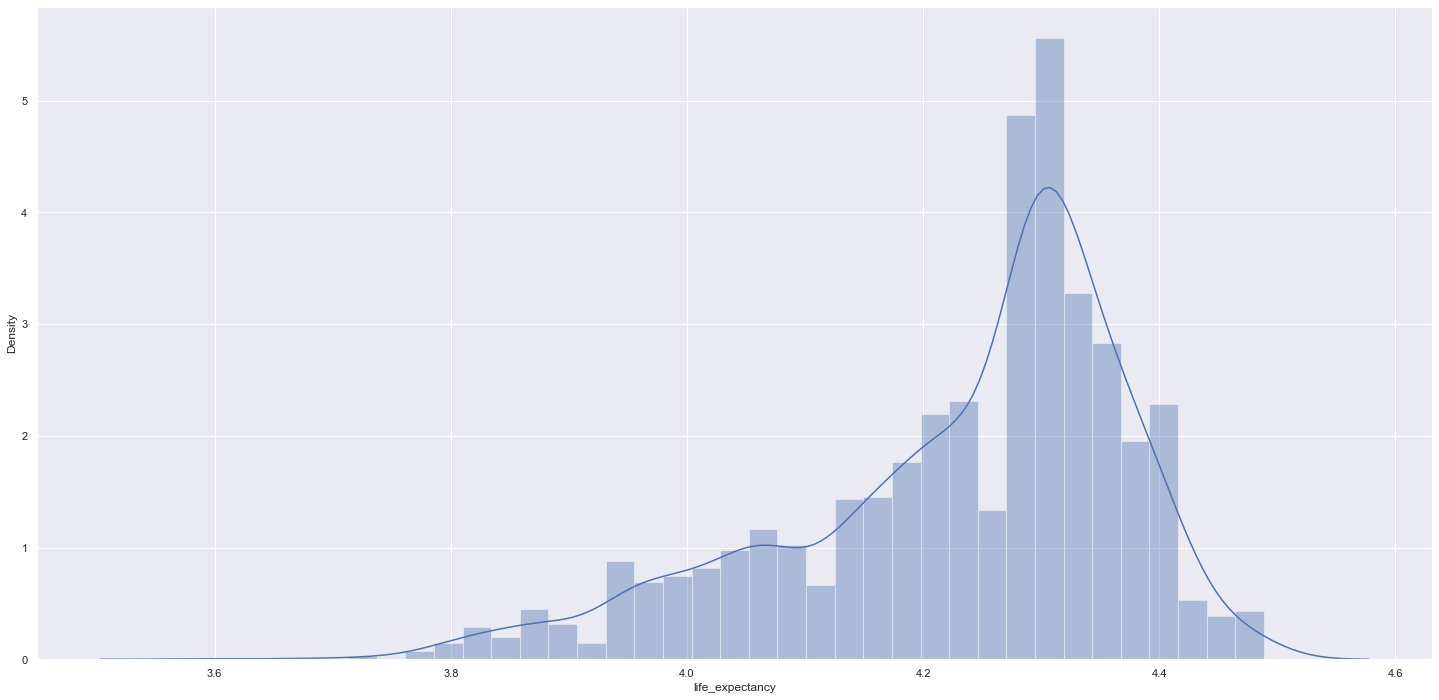

In [431]:
df3['life_expectancy']=np.log(df3['life_expectancy'])
sns.distplot(df3['life_expectancy']);


## Features Selection

In [432]:
df4=df3.copy()
df4.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,total_expenditure,diphtheria,hiv_aids,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling,emission,pop_male,pop_female,pop_total,density,lat,long,continent,code,perc_female,emission_pop,gdp
0,0,16,1,4.17,263.00,2.81,0.01,0.01,65.00,3.17,19.10,3.04,6.00,8.16,65.00,0.10,17.20,17.30,0.48,10.10,-0.08,1.22,1.12,1.16,-0.17,33.77,66.24,1,1,-1.31,-0.21,-0.28
1,0,15,1,4.09,271.00,2.90,0.01,0.01,62.00,1.32,18.60,3.15,58.00,8.18,62.00,0.10,17.50,17.50,0.48,10.00,-0.09,1.17,1.08,1.12,-0.18,33.77,66.24,1,1,-1.28,-0.21,-0.27
2,0,14,1,4.09,268.00,3.00,0.01,0.01,64.00,1.15,18.10,3.27,62.00,8.13,64.00,0.10,17.70,17.70,0.47,9.90,-0.09,1.12,1.03,1.07,-0.20,33.77,66.24,1,1,-1.24,-0.22,-0.27
3,0,13,1,4.09,272.00,3.14,0.01,0.02,67.00,7.72,17.60,3.42,67.00,8.52,67.00,0.10,17.90,18.00,0.46,9.80,-0.10,1.07,0.98,1.02,-0.21,33.77,66.24,1,1,-1.19,-0.22,-0.27
4,0,12,1,4.08,275.00,3.24,0.01,-0.13,68.00,8.35,17.20,3.58,68.00,7.87,68.00,0.10,18.20,18.20,0.45,9.50,-0.10,1.02,0.94,0.97,-0.23,33.77,66.24,1,1,-1.15,-0.22,-0.27


In [433]:
# # # Remocao de atributos irrelevantes
cols_drop = ['code','lat','long','pop_total','perc_female']
df4=df4.drop(cols_drop, axis=1)


### Split dataframe into training and test dataset

In [434]:
# training dataset
X_train = df4[df4['year'] < 14]
y_train = X_train['life_expectancy']


# test dataset
X_test = df4[df4['year'] >= 14]
y_test = X_test['life_expectancy']

print( 'Training Min Date: {}'.format( X_train['year'].min() ) )
print( 'Training Max Date: {}'.format( X_train['year'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['year'].min() ) )
print( 'Test Max Date: {}'.format( X_test['year'].max() ) )

Training Min Date: 1
Training Max Date: 13

Test Min Date: 14
Test Max Date: 16


In [435]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2332 entries, 3 to 2937
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   country                          2332 non-null   int32  
 1   year                             2332 non-null   int32  
 2   status                           2332 non-null   int32  
 3   life_expectancy                  2332 non-null   float64
 4   adult_mortality                  2332 non-null   float64
 5   infant_deaths                    2332 non-null   float64
 6   alcohol                          2332 non-null   float64
 7   percentage_expenditure           2332 non-null   float64
 8   hepatitis_b                      2332 non-null   float64
 9   measles                          2332 non-null   float64
 10  bmi                              2332 non-null   float64
 11  under_five_deaths                2332 non-null   float64
 12  polio               

### Seleçao por subset - Boruta

In [436]:
# ## training and test dataset for Boruta
X_train_n = X_train.drop(['life_expectancy','year'],axis=1).values #retorna uma matrix
y_train_n = y_train.values.ravel()


# # ## define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 ) # cria as arvores em paralelo

# # define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=15 ).fit( X_train_n, y_train_n )# devo passar um vetor 

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	22
Tentative: 	3
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	22
Tentative: 	2
Rejected: 	1
Iteration: 	10 / 100
Confirmed: 	22
Tentative: 	2
Rejected: 	1
Iteration: 	11 / 100
Confirmed: 	22
Tentative: 	2
Rejected: 	1
Iteration: 	12 / 100
Confirmed: 	22
Tentative: 	2
Rejected: 	1
Iteration: 	13 / 100
Confirmed: 	22
Tentative: 	2
Rejected: 	1
Iteration: 	14 / 100
Confirmed: 	22
Tentative: 	2
Rejected: 	1
Iteration: 	15 / 100
Confirmed: 	22
Tentative: 	2
Rejected: 	1
Iteration: 	16 / 100
Confirmed: 	22
Tentative: 	2
Rejected: 	1
I

In [437]:
cols_selected = boruta.support_.tolist()

## best features
X_train_fs = X_train.drop( [ 'life_expectancy','year'], axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# ## not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) ) 

In [438]:
cols_selected_boruta

['country',
 'adult_mortality',
 'infant_deaths',
 'alcohol',
 'percentage_expenditure',
 'hepatitis_b',
 'bmi',
 'under_five_deaths',
 'polio',
 'total_expenditure',
 'diphtheria',
 'hiv_aids',
 'thinness_1_19_years',
 'thinness_5_9_years',
 'income_composition_of_resources',
 'schooling',
 'emission',
 'pop_male',
 'pop_female',
 'density',
 'continent',
 'emission_pop',
 'gdp']

In [439]:
cols_not_selected_boruta

['measles', 'status']

In [440]:
features_selection= [
'country',
 'adult_mortality',
 'infant_deaths',
 'alcohol',
 'percentage_expenditure',
 'hepatitis_b',
 'bmi',
 'under_five_deaths',
 'polio',
 'total_expenditure',
 'diphtheria',
 'hiv_aids',
 'thinness_1_19_years',
 'thinness_5_9_years',
 'income_composition_of_resources',
 'schooling',
 'emission',
 'pop_male',
 'pop_female',
 'density',
 'continent',
 'emission_pop',
 'gdp'
]

# columns to add
feat_to_add = ['life_expectancy','year']

features_selection_full = features_selection.copy()
features_selection_full.extend( feat_to_add )

In [441]:
features_selection_full

['country',
 'adult_mortality',
 'infant_deaths',
 'alcohol',
 'percentage_expenditure',
 'hepatitis_b',
 'bmi',
 'under_five_deaths',
 'polio',
 'total_expenditure',
 'diphtheria',
 'hiv_aids',
 'thinness_1_19_years',
 'thinness_5_9_years',
 'income_composition_of_resources',
 'schooling',
 'emission',
 'pop_male',
 'pop_female',
 'density',
 'continent',
 'emission_pop',
 'gdp',
 'life_expectancy',
 'year']

## Machine Learning Modelling

In [514]:
x_train = X_train[ features_selection ]
x_test = X_test[ features_selection ]

# Time Series Data Preparation
x_training = X_train[ features_selection_full ]

### Linear regression model 

In [515]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

In [516]:
print( 'Score Train: {}'.format( lr.score(x_train,y_train) ))
print( 'Score Test: {}'.format( lr.score(x_test,y_test) ))

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

Score Train: 0.8390243732916304
Score Test: 0.8043404439389107


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,2.85,0.04,3.73


In [517]:
print("Descrição do modelo: ")
s = ["{0}: {1:0.5f}".format(a, v) for a, v in zip(features_selection_full, lr.coef_)]
print("w: {}  b: {:.5f}".format(s, lr.intercept_))
print("Número de atributos usados: {}".format(np.sum(lr.coef_ != 0)))

Descrição do modelo: 
w: ['country: 0.00008', 'adult_mortality: -0.00024', 'infant_deaths: 0.02971', 'alcohol: 0.00098', 'percentage_expenditure: -0.00045', 'hepatitis_b: -0.00023', 'bmi: 0.00064', 'under_five_deaths: -0.02903', 'polio: 0.00045', 'total_expenditure: -0.00047', 'diphtheria: 0.00061', 'hiv_aids: -0.00885', 'thinness_1_19_years: 0.00016', 'thinness_5_9_years: 0.00141', 'income_composition_of_resources: 0.06094', 'schooling: 0.00997', 'emission: -0.00005', 'pop_male: 0.00517', 'pop_female: -0.00431', 'density: 0.00203', 'continent: 0.01307', 'emission_pop: 0.00012', 'gdp: 0.01542']  b: 3.98568
Número de atributos usados: 23


#### Linear Regression Model - Cross Validation

In [518]:
lr_result_cv = cross_validation( x_training, 3, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,3.17 +/- 0.208,0.05 +/- 0.004,4.12 +/- 0.178


### Linear Regression Regularized Model - Lasso

In [519]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

In [520]:
print( 'Score Train: {}'.format( lrr.score(x_train,y_train) ))
print( 'Score Test: {}'.format( lrr.score(x_test,y_test) ))

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

Score Train: 0.8206015610639548
Score Test: 0.7982589525916054


,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,2.83,0.04,3.74


In [521]:
print("Descrição do modelo: ")
s = ["{0}: {1:0.5f}".format(a, v) for a, v in zip(features_selection_full, lrr.coef_)]
print("w: {}  b: {:.5f}".format(s, lrr.intercept_))
print("Número de atributos usados: {}".format(np.sum(lrr.coef_ != 0)))

Descrição do modelo: 
w: ['country: 0.00006', 'adult_mortality: -0.00029', 'infant_deaths: -0.00000', 'alcohol: 0.00027', 'percentage_expenditure: 0.00086', 'hepatitis_b: -0.00027', 'bmi: 0.00087', 'under_five_deaths: -0.00200', 'polio: 0.00052', 'total_expenditure: -0.00000', 'diphtheria: 0.00078', 'hiv_aids: -0.00875', 'thinness_1_19_years: -0.00000', 'thinness_5_9_years: 0.00000', 'income_composition_of_resources: 0.00000', 'schooling: 0.01317', 'emission: 0.00004', 'pop_male: 0.00189', 'pop_female: 0.00000', 'density: 0.00185', 'continent: 0.00567', 'emission_pop: 0.00000', 'gdp: 0.00567']  b: 3.99064
Número de atributos usados: 16


#### Linear Regression Regularized Model - Cross Validation

In [522]:
lrr_result_cv = cross_validation( x_training, 3, 'Linear Regression - Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,3.13 +/- 0.134,0.05 +/- 0.003,4.1 +/- 0.157


### Linear Regression Regularized Model - Ridge

In [523]:
# model
lrri = Ridge( alpha=0.1 ).fit( x_train, y_train )

# prediction
yhat_lrri = lrri.predict( x_test )


In [524]:
print( 'Score Train: {}'.format( lrri.score(x_train,y_train) ))
print( 'Score Test: {}'.format( lrri.score(x_test,y_test) ))

# performance
lrri_result = ml_error( 'Linear Regression - Ridge', np.expm1( y_test ), np.expm1( yhat_lrri ) )
lrri_result

Score Train: 0.8390243530177884
Score Test: 0.804328400189994


,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Ridge,2.85,0.04,3.73


In [525]:
print("Descrição do modelo: ")
s = ["{0}: {1:0.5f}".format(a, v) for a, v in zip(features_selection_full, lrri.coef_)]
print("w: {}  b: {:.5f}".format(s, lrri.intercept_))
print("Número de atributos usados: {}".format(np.sum(lrri.coef_ != 0)))

Descrição do modelo: 
w: ['country: 0.00008', 'adult_mortality: -0.00024', 'infant_deaths: 0.02970', 'alcohol: 0.00098', 'percentage_expenditure: -0.00045', 'hepatitis_b: -0.00023', 'bmi: 0.00064', 'under_five_deaths: -0.02902', 'polio: 0.00045', 'total_expenditure: -0.00047', 'diphtheria: 0.00061', 'hiv_aids: -0.00885', 'thinness_1_19_years: 0.00015', 'thinness_5_9_years: 0.00141', 'income_composition_of_resources: 0.06078', 'schooling: 0.00997', 'emission: -0.00005', 'pop_male: 0.00514', 'pop_female: -0.00428', 'density: 0.00203', 'continent: 0.01306', 'emission_pop: 0.00012', 'gdp: 0.01542']  b: 3.98570
Número de atributos usados: 23


#### Linear Regression Regularized Model - Cross Validation

In [526]:
lrri_result_cv = cross_validation( x_training, 3, 'Linear Regression - Ridge', lrri, verbose=False )
lrri_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Ridge,3.17 +/- 0.207,0.05 +/- 0.004,4.12 +/- 0.177


### Random Forest Regressor

In [493]:
RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [494]:
# model
rf = RandomForestRegressor( bootstrap= True,
                           criterion='mse',
                           min_samples_leaf= 1,
                           min_samples_split= 2,
                           n_estimators=100, 
                           n_jobs=-1, 
                          ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

In [495]:
print( 'Score Train: {}'.format( rf.score(x_train,y_train) ))
print( 'Score Test: {}'.format( rf.score(x_test,y_test) ))

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

Score Train: 0.9954453690320629
Score Test: 0.918272800101161


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,1.49,0.02,2.31


#### Ramdom Forest- Cross Validation

In [496]:
rf_result_cv = cross_validation( x_training, 3, 'Random Forest Regressor', rf, verbose=False )
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,1.63 +/- 0.092,0.03 +/- 0.001,2.49 +/- 0.104


### XGBoost Regressor

In [497]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              max_depth=5, 
                              subsample=0.7
                             ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1.74,0.03,2.49


#### XGBoost - Cross Validation

In [498]:
xgb_result_cv = cross_validation( x_training, 3, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1.77 +/- 0.023,0.03 +/- 0.0,2.56 +/- 0.015


## Performance Metrics

In [499]:
modelling_result = pd.concat( [lr_result, lrr_result,lrri_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,1.49,0.02,2.31
0,XGBoost Regressor,1.74,0.03,2.49
0,Linear Regression,2.85,0.04,3.73
0,Linear Regression - Ridge,2.85,0.04,3.73
0,Linear Regression - Lasso,2.83,0.04,3.74


### Real Performance - Cross Validation

In [500]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, lrri_result_cv,rf_result_cv, xgb_result_cv] )
modelling_result_cv.sort_values( 'RMSE CV' )

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,1.63 +/- 0.092,0.03 +/- 0.001,2.49 +/- 0.104
0,XGBoost Regressor,1.77 +/- 0.023,0.03 +/- 0.0,2.56 +/- 0.015
0,Linear Regression - Lasso,3.13 +/- 0.134,0.05 +/- 0.003,4.1 +/- 0.157
0,Linear Regression,3.17 +/- 0.208,0.05 +/- 0.004,4.12 +/- 0.178
0,Linear Regression - Ridge,3.17 +/- 0.207,0.05 +/- 0.004,4.12 +/- 0.178


## Fine Tunning

### Random search

In [463]:
from sklearn.model_selection       import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble              import RandomForestClassifier


In [464]:
# Create the parameter grid based on the results of random search 
bootstrap= [1,0],
criterion=['mse']
min_samples_leaf= [0.5, 0.75, 1, 2],
min_samples_split= [0.5, 0.75, 1, 2],
n_estimators= [10, 40, 80, 160, 250]


param_grid = {
   'bootstrap': bootstrap,
   'criterion': criterion,
   'min_samples_leaf': min_samples_leaf,
   'min_samples_split': min_samples_split,
   'n_estimators':n_estimators  
}

n_combinations=1
for k in param_grid.keys():n_combinations*= len(param_grid[k])
    
print('numbers_of_combination =', n_combinations)
    
param_grid



numbers_of_combination = 5


{'bootstrap': ([1, 0],),
 'criterion': ['mse'],
 'min_samples_leaf': ([0.5, 0.75, 1, 2],),
 'min_samples_split': ([0.5, 0.75, 1, 2],),
 'n_estimators': [10, 40, 80, 160, 250]}

In [465]:
# rf = RandomForestRegressor()
    
# model_rf = GridSearchCV(estimator = rf, 
#                               param_grid= param_grid, 
#                               cv = 3, 
#                               return_train_score=1,
#                               n_jobs = -1, 
#                               verbose = 2)
#  # performance
# result = cross_validation( x_training, 3, 'Random Forest Regressor', model_rf, verbose=True )
# #final_result = pd.concat( [final_result, result] )
       
# #final_result


### XGBoost

In [466]:
param = {
   'n_estimators': [100, 500, 1000,10000],
   'max_depth': [1, 2, 5],
   'subsample': [0.1, 0.5, 0.7]
  # 'min_child_weight': [10, 30, 50]
       }


MAX_EVAL = 10

In [467]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
   # choose values for parameters randomly
   hp = { k: np.random.choice( v, 1 )[0] for k, v in param.items() }
   print( hp )
   
   # model
   model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'], 
                                 max_depth=hp['max_depth'], 
                                 subsample=hp['subsample'],
                                 #min_child_weight=hp['min_child_weight'] 
                               )

   # performance
   result = cross_validation( x_training, 3, 'XGBoost Regressor', model_xgb, verbose=True )
   final_result = pd.concat( [final_result, result] )
       
final_result


{'n_estimators': 1000, 'max_depth': 5, 'subsample': 0.7}

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 10000, 'max_depth': 5, 'subsample': 0.5}

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 100, 'max_depth': 2, 'subsample': 0.1}

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 500, 'max_depth': 1, 'subsample': 0.7}

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 10000, 'max_depth': 2, 'subsample': 0.1}

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 100, 'max_depth': 1, 'subsample': 0.7}

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 500, 'max_depth': 5, 'subsample': 0.5}

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 1000, 'max_depth': 5, 'subsample': 0.5}

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 100, 'max_depth': 5, 'subsample': 0.5}

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 10000, 'max_de

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1.76 +/- 0.018,0.03 +/- 0.0,2.55 +/- 0.008
0,XGBoost Regressor,1.83 +/- 0.039,0.03 +/- 0.001,2.59 +/- 0.071
0,XGBoost Regressor,2.47 +/- 0.217,0.04 +/- 0.004,3.26 +/- 0.268
0,XGBoost Regressor,2.1 +/- 0.042,0.03 +/- 0.001,2.92 +/- 0.042
0,XGBoost Regressor,3.59 +/- 0.121,0.05 +/- 0.001,4.63 +/- 0.135
0,XGBoost Regressor,2.43 +/- 0.011,0.04 +/- 0.001,3.26 +/- 0.025
0,XGBoost Regressor,1.83 +/- 0.038,0.03 +/- 0.001,2.59 +/- 0.07
0,XGBoost Regressor,1.83 +/- 0.038,0.03 +/- 0.001,2.59 +/- 0.071
0,XGBoost Regressor,1.83 +/- 0.04,0.03 +/- 0.001,2.59 +/- 0.074
0,XGBoost Regressor,2.04 +/- 0.084,0.03 +/- 0.001,2.85 +/- 0.104


### Final Model

#### Final tune XGBoost

In [468]:
param_tuned = {
    'n_estimators': 500,
    'max_depth': 2,
    'subsample': 0.7,
        }


In [469]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1.68,0.02,2.38


#### Final Model Random Forest

In [470]:
# model
rf = RandomForestRegressor( bootstrap= True,
                           criterion='mse',
                           min_samples_leaf= 1,
                           min_samples_split= 2,
                           n_estimators=100, 
                           n_jobs=-1, 
                          ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

print( 'Score Train: {}'.format( rf.score(x_train,y_train) ))
print( 'Score Test: {}'.format( rf.score(x_test,y_test) ))

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

Score Train: 0.995278693318262
Score Test: 0.9153934332621287


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,1.50,0.02,2.35


## Translation and interpretation of the error

In [471]:
df5 = X_test[ features_selection_full ]

# rescale
df5['life_expectancy'] = np.expm1( df5['life_expectancy'] )
df5['predictions'] = np.expm1( yhat_rf )
df5.head()

,country,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,bmi,under_five_deaths,polio,total_expenditure,diphtheria,hiv_aids,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling,emission,pop_male,pop_female,density,continent,emission_pop,gdp,life_expectancy,year,predictions
0,0,263.00,2.81,0.01,0.01,65.00,19.10,3.04,6.00,8.16,65.00,0.10,17.20,17.30,0.48,10.10,-0.08,1.22,1.12,-0.17,1,-0.21,-0.28,64.00,16,60.78
1,0,271.00,2.90,0.01,0.01,62.00,18.60,3.15,58.00,8.18,62.00,0.10,17.50,17.50,0.48,10.00,-0.09,1.17,1.08,-0.18,1,-0.21,-0.27,58.90,15,59.30
2,0,268.00,3.00,0.01,0.01,64.00,18.10,3.27,62.00,8.13,64.00,0.10,17.70,17.70,0.47,9.90,-0.09,1.12,1.03,-0.20,1,-0.22,-0.27,58.90,14,59.13
16,1,74.00,-0.14,4.60,0.66,99.00,58.00,-0.15,99.00,6.00,99.00,0.10,1.20,1.30,0.76,14.20,-0.04,-0.24,-0.25,0.29,2,0.13,0.02,76.80,16,74.95
17,1,8.00,-0.14,4.51,0.80,98.00,57.20,-0.12,98.00,5.88,98.00,0.10,1.20,1.30,0.76,14.20,-0.04,-0.24,-0.25,0.29,2,0.12,0.08,76.50,15,75.05


### Business Performance

In [472]:
# sum of predictions
df51 = df5[['country', 'predictions']].groupby( 'country' ).mean().reset_index()

# # MAE and MAPE
df5_aux1 = df5[['country', 'life_expectancy', 'predictions']].groupby( 'country' ).apply( lambda x: mean_absolute_error( x['life_expectancy'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df5_aux2 = df5[['country', 'life_expectancy', 'predictions']].groupby( 'country' ).apply( lambda x: mean_absolute_percentage_error( x['life_expectancy'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df5_aux3 = pd.merge( df5_aux1, df5_aux2, how='inner', on='country' )
df52 = pd.merge( df51, df5_aux3, how='inner', on='country' )

# # Scenarios
df52['worst_scenario'] = df52['predictions'] - df52['MAE']
df52['best_scenario'] = df52['predictions'] + df52['MAE']

# # order columns
df52 = df52[['country', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [473]:

a=['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015']
b=np.arange(1,17,1)
year_dict = dict(zip(b, a))
df5['year']=df5['year'].map(year_dict)
df5.head()

df52.sort_values( 'MAPE', ascending=False ).head()


,country,predictions,worst_scenario,best_scenario,MAE,MAPE
143,143,59.56,50.03,69.09,9.53,0.19
149,149,56.41,49.20,63.63,7.22,0.11
179,179,54.54,48.67,60.40,5.86,0.09
178,178,55.94,50.91,60.97,5.03,0.08
25,25,63.04,58.40,67.69,4.64,0.08


### Total Performance

In [474]:
df53 = df52[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.mean( x ), 
                                                            axis=0 ).reset_index().rename( columns=
                                                            {'index': 'Scenario', 0:'Years'} )
df53['Years'] = df53['Years'].map( '{:,.2f}'.format )
df53

,Scenario,Years
0,predictions,70.36
1,worst_scenario,68.86
2,best_scenario,71.86


### Machine Learning Performance

In [475]:
df5['error'] = df5['life_expectancy'] - df5['predictions']
df5['error_rate'] = df5['predictions'] / df5['life_expectancy']


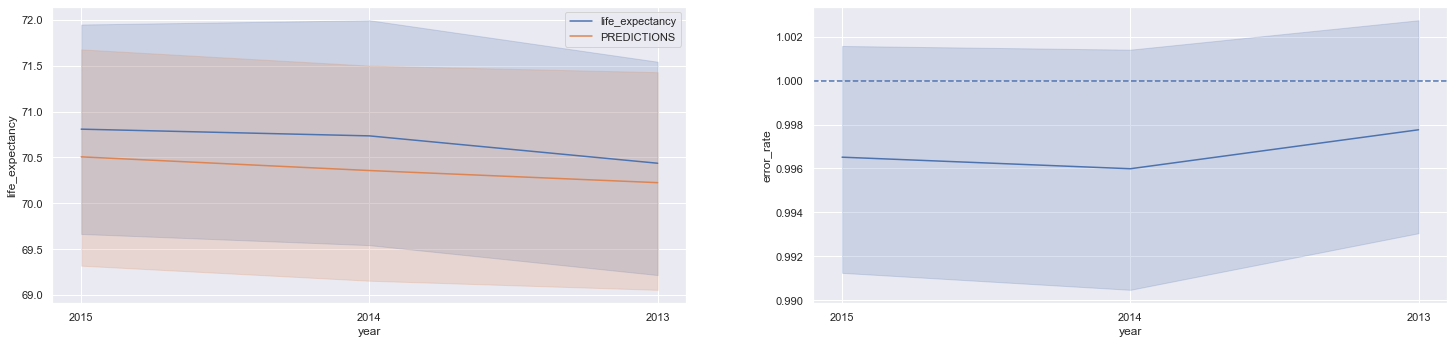

In [476]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='year', y='life_expectancy', data=df5, label='life_expectancy' )
sns.lineplot( x='year', y='predictions', data=df5, label='PREDICTIONS' );

plt.subplot( 2, 2, 2 )
sns.lineplot( x='year', y='error_rate', data=df5)
plt.axhline( 1, linestyle='--')

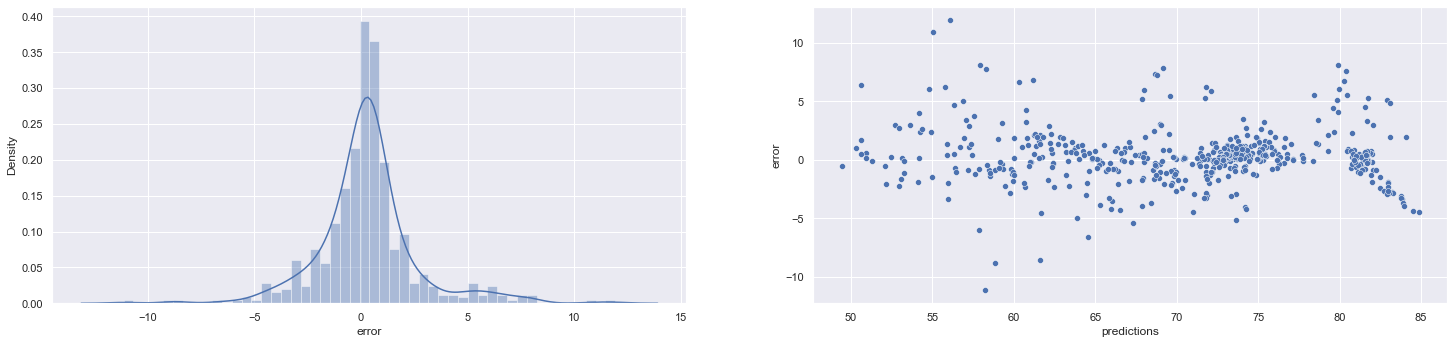

In [477]:

plt.subplot( 2, 2, 3 )
sns.distplot( df5['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df5['predictions'], df5['error'] );